СРАВНЕНИЕ МЕТОДОВ БАЛАНСИРОВКИ
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ

Тестирование метода: UNDERSAMPLING
----------------------------------------
ЗАПУСК АНАЛИЗА TITANIC DATASET (UNDERSAMPLING)
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
БАЛАНСИРОВКА ДАННЫХ (UNDERSAMPLING):
   До балансировки: {0: 439, 1: 273}
   После балансировки: {0: 273, 1: 273}
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': True}
      Лучший F1: 0.8199
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 0.1}
      Лучший F1: 0.7968
   Подбор параметров для AdaBoost...
      Лучшие параметры: {'n_estimators': 100, 'learning_rate': 0.5, 'algorithm': 'SAMME'}
      Лучший F1: 0.8089
   Подбор параметров для LightGBM...
      Лучшие параметры: {'subsample': 0.9, 'num_leaves': 100, 'n_estimators': 200, 'ma

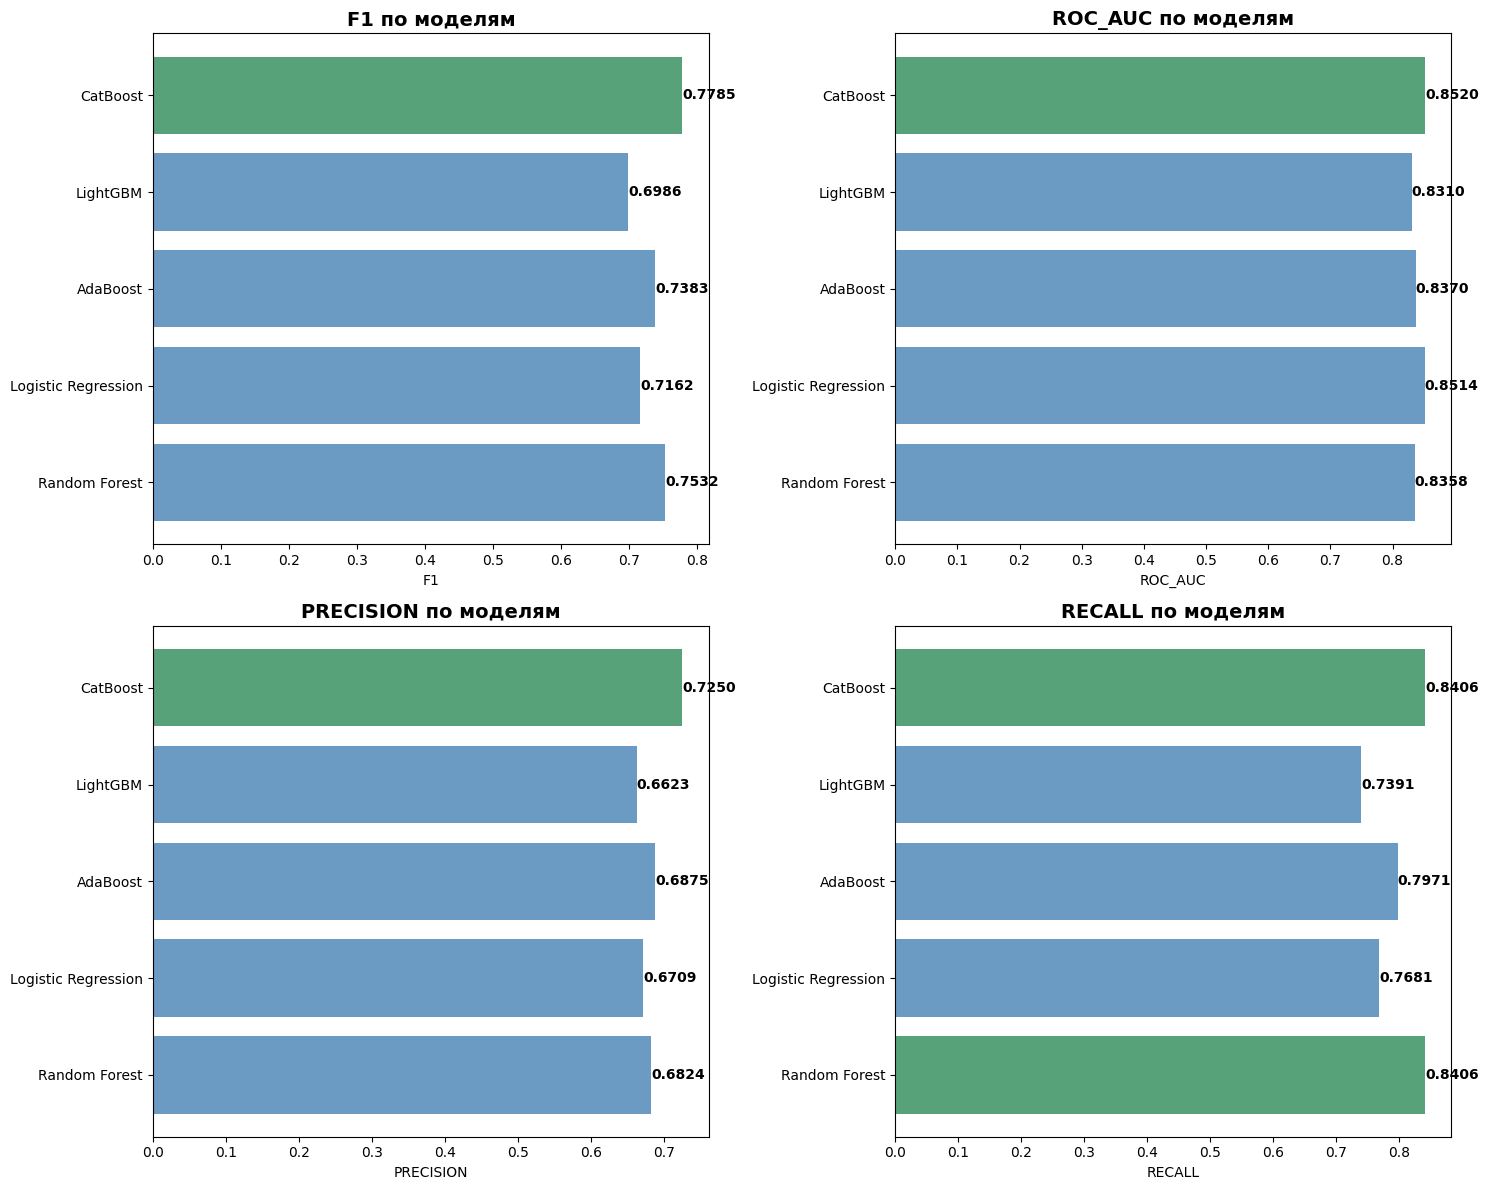

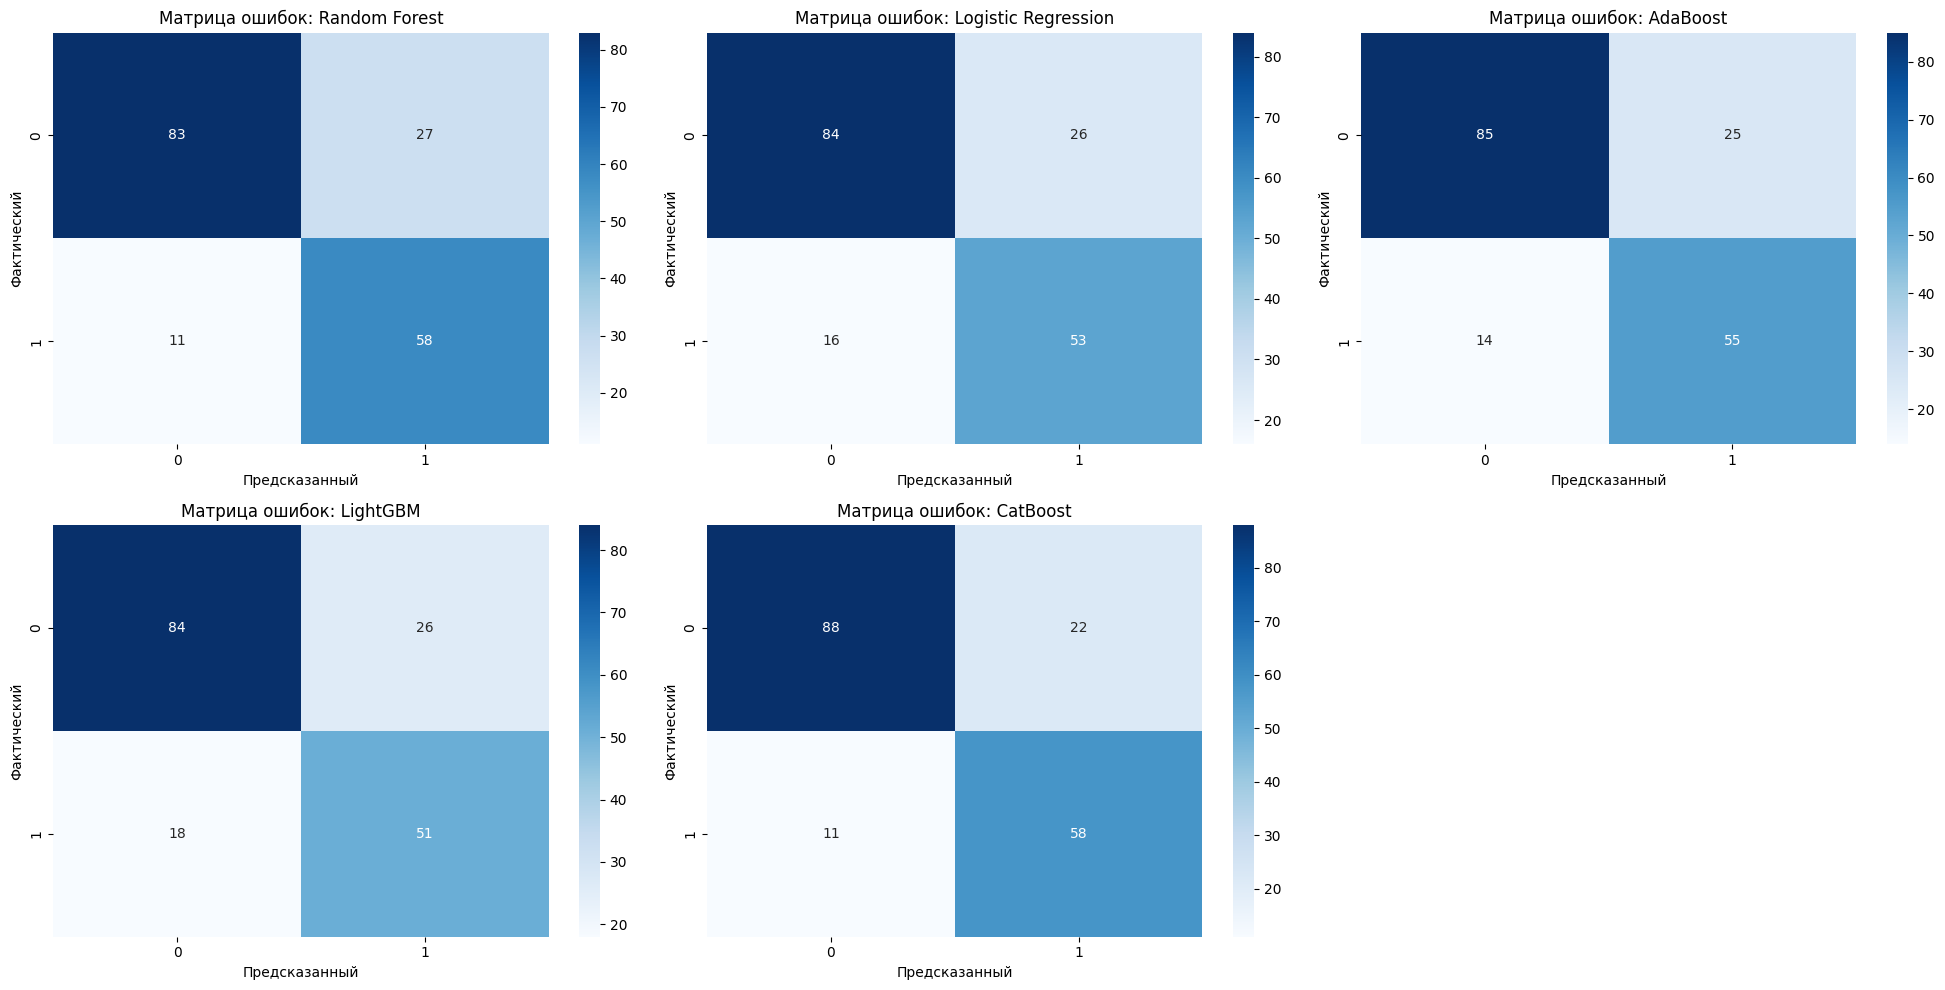


КОМПЛЕКСНЫЙ ОТЧЕТ (UNDERSAMPLING)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод балансировки: undersampling
   Размер после балансировки: (546, 12)
   Финальный баланс: {0: 273, 1: 273}

ЛУЧШАЯ МОДЕЛЬ: CatBoost
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6}

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7785
   ROC-AUC:        0.8520
   Accuracy:       0.8156
   Precision:      0.7250
   Recall:         0.8406

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
           CatBoost  0.778523 0.851976   0.725000 0.840580  0.815642
      Random Forest  0.753247 0.835771   0.682353 0.840580  0.787709
           AdaBoost  0.738255 0.837022   0.687500 0.797101  0.782123
Logistic Regression  0.716216 0.851383   0.670886 0.768116  0.765363
           LightGBM  0.698630 0.830962   0.662338 0.739130  0.754190

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (Random Forest):
   Sex: 36.7%
   Title: 13.2%


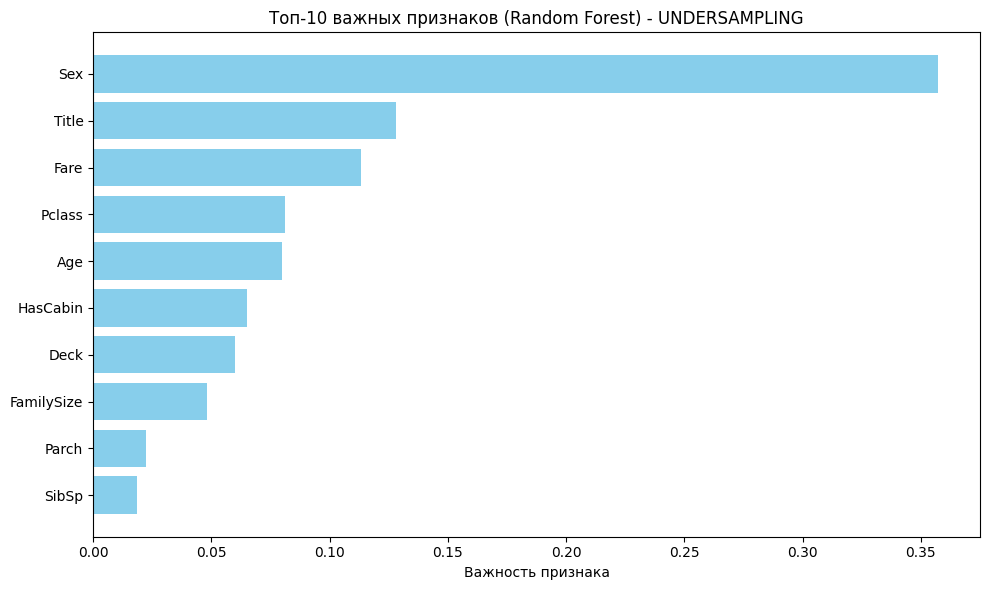


Тестирование метода: OVERSAMPLING
----------------------------------------
ЗАПУСК АНАЛИЗА TITANIC DATASET (OVERSAMPLING)
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
БАЛАНСИРОВКА ДАННЫХ (OVERSAMPLING):
   До балансировки: {0: 439, 1: 273}
   После балансировки: {1: 439, 0: 439}
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}
      Лучший F1: 0.8552
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 0.1}
      Лучший F1: 0.7913
   Подбор параметров для AdaBoost...
      Лучшие параметры: {'n_estimators': 200, 'learning_rate': 0.5, 'algorithm': 'SAMME'}
      Лучший F1: 0.8094
   Подбор параметров для LightGBM...
      Лучшие параметры: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
     

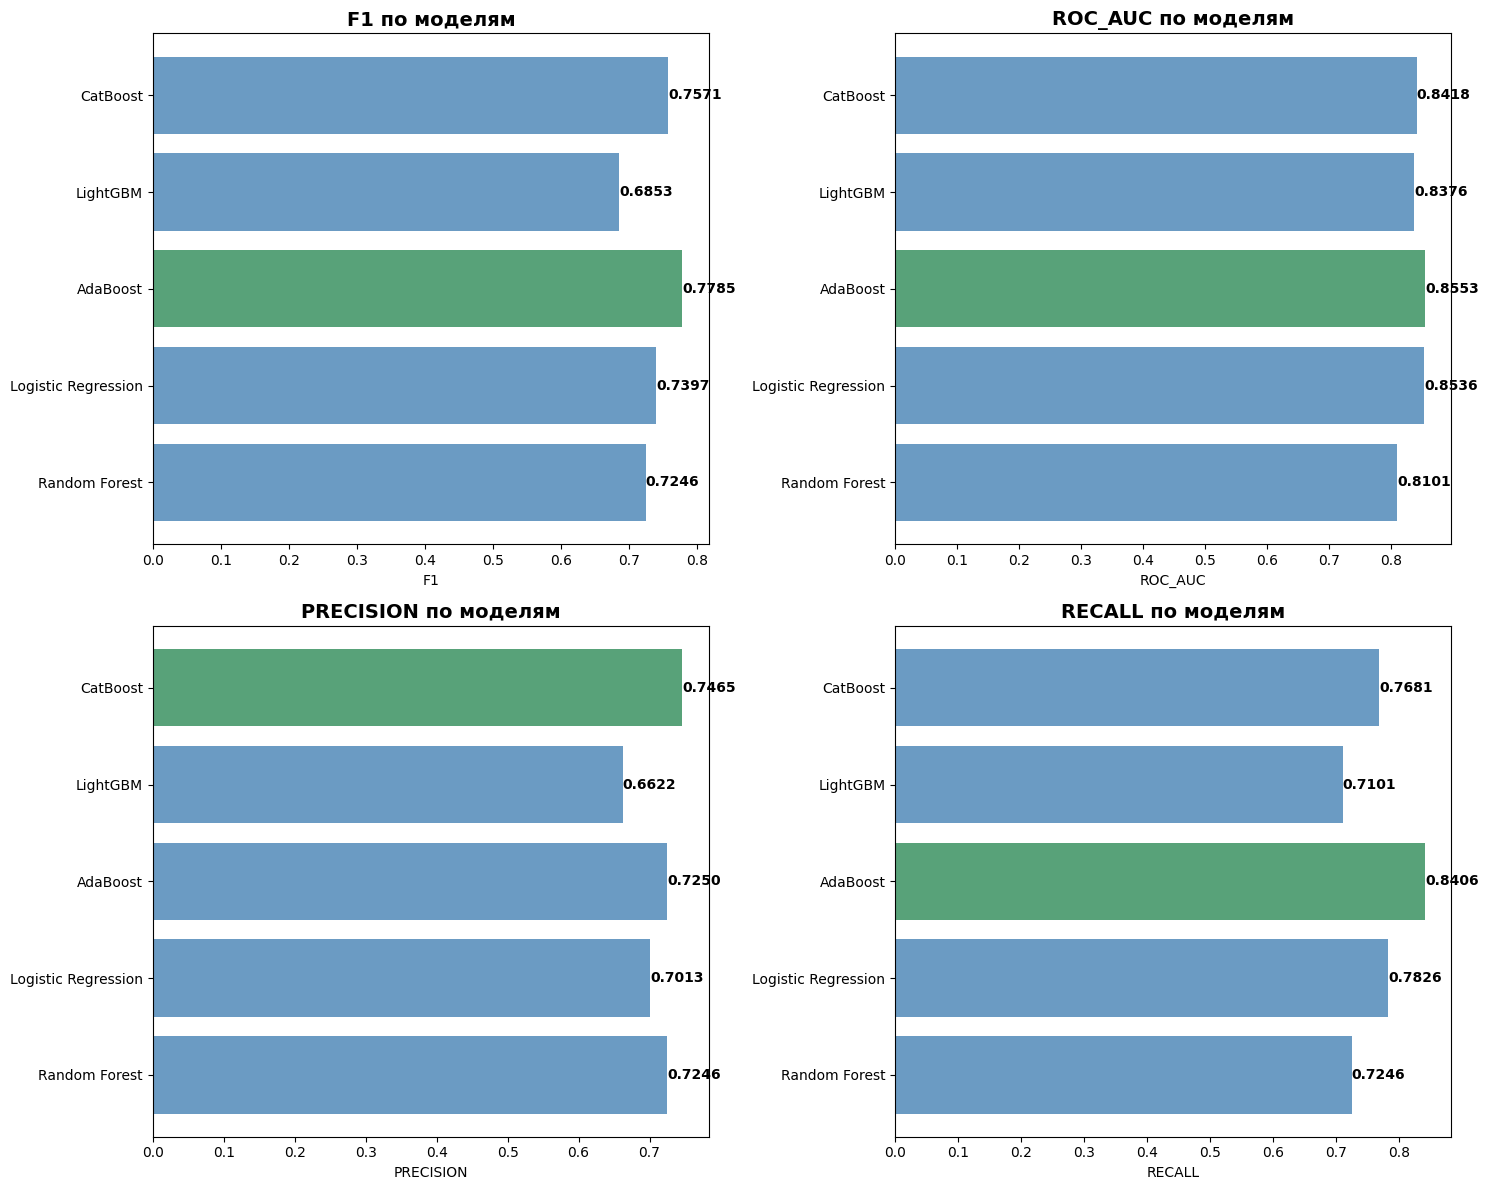

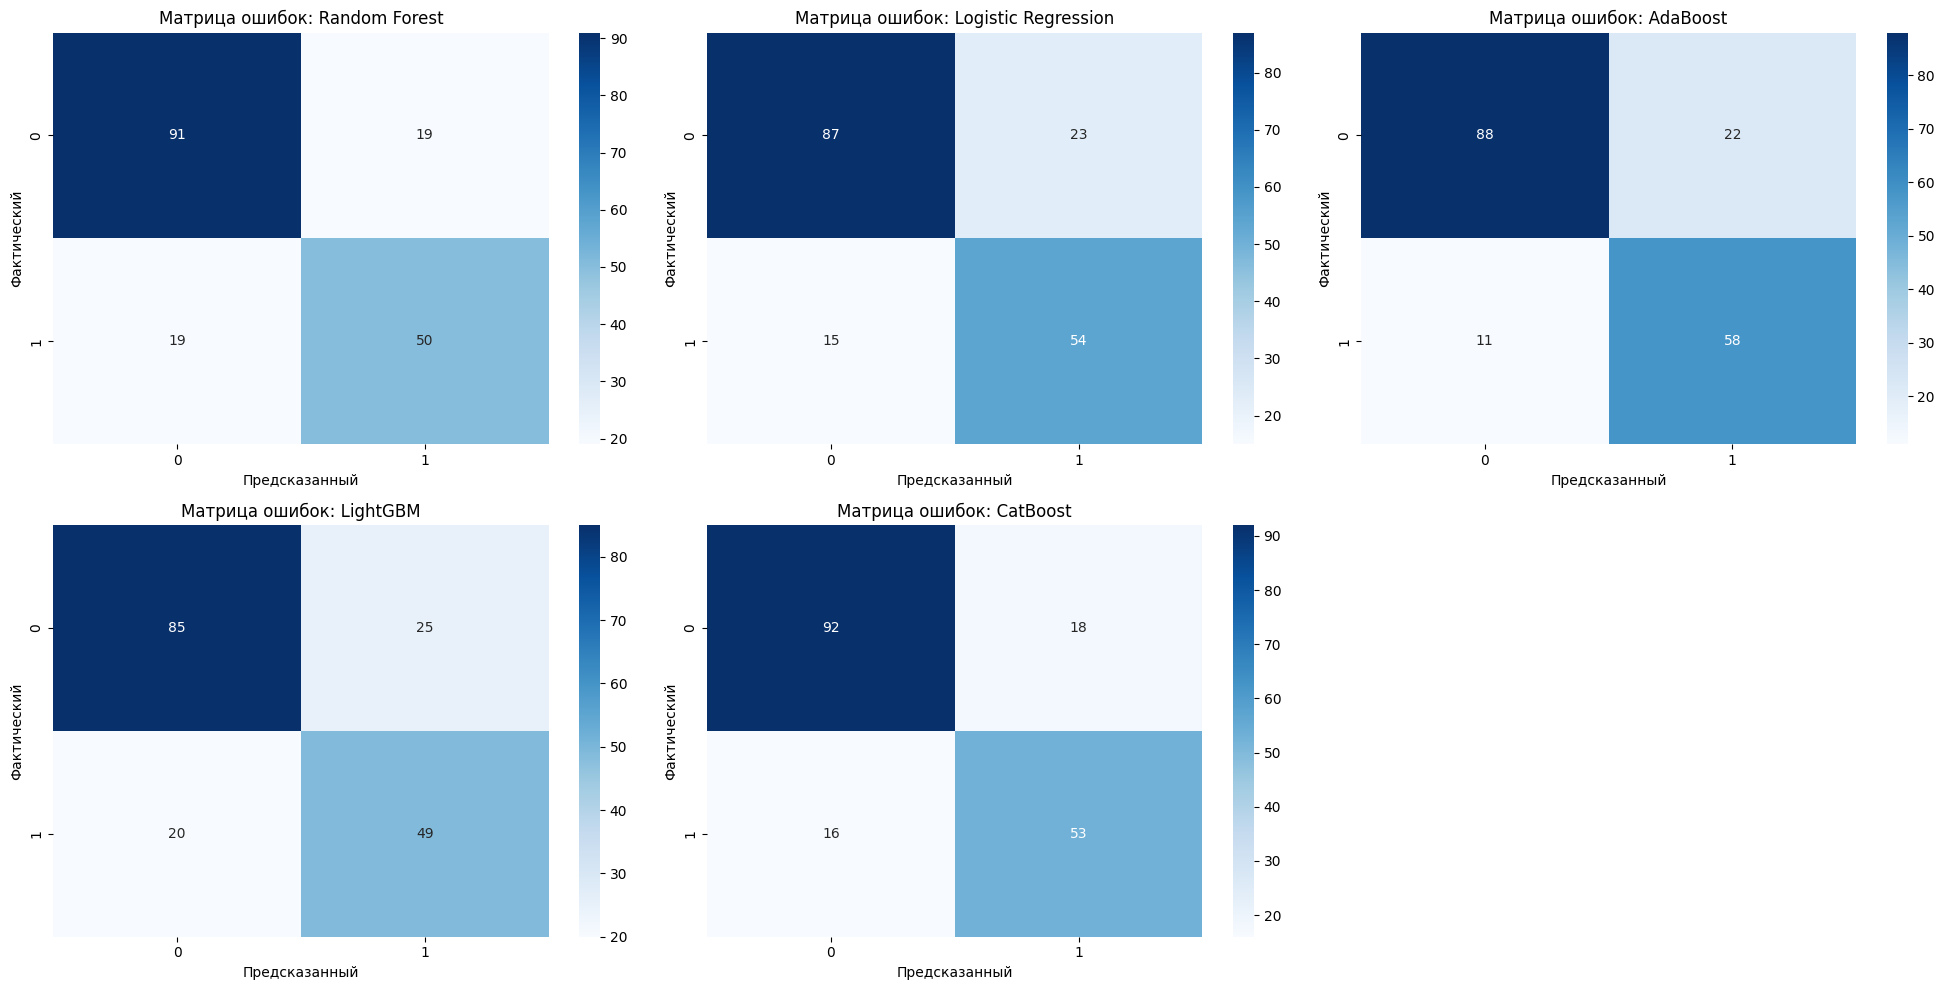


КОМПЛЕКСНЫЙ ОТЧЕТ (OVERSAMPLING)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод балансировки: oversampling
   Размер после балансировки: (878, 12)
   Финальный баланс: {1: 439, 0: 439}

ЛУЧШАЯ МОДЕЛЬ: AdaBoost
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   AdaBoost: {'n_estimators': 200, 'learning_rate': 0.5, 'algorithm': 'SAMME'}

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7785
   ROC-AUC:        0.8553
   Accuracy:       0.8156
   Precision:      0.7250
   Recall:         0.8406

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
           AdaBoost  0.778523 0.855270   0.725000 0.840580  0.815642
           CatBoost  0.757143 0.841765   0.746479 0.768116  0.810056
Logistic Regression  0.739726 0.853623   0.701299 0.782609  0.787709
      Random Forest  0.724638 0.810145   0.724638 0.724638  0.787709
           LightGBM  0.685315 0.837615   0.662162 0.710145  0.748603

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (Random Forest):
   Fare: 23.9%
   Age: 22.4%
   Sex: 2

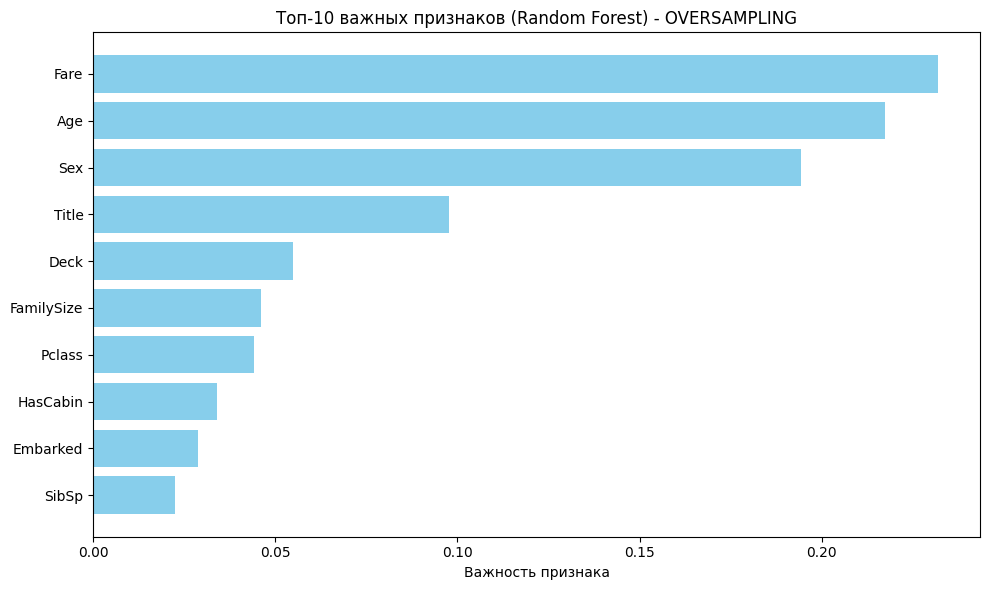


Тестирование метода: SMOTE
----------------------------------------
ЗАПУСК АНАЛИЗА TITANIC DATASET (SMOTE)
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
БАЛАНСИРОВКА ДАННЫХ (SMOTE):
   До балансировки: {0: 439, 1: 273}
   После балансировки: {1: 439, 0: 439}
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': True}
      Лучший F1: 0.8429
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 0.1}
      Лучший F1: 0.8086
   Подбор параметров для AdaBoost...
      Лучшие параметры: {'n_estimators': 50, 'learning_rate': 1, 'algorithm': 'SAMME'}
      Лучший F1: 0.8329
   Подбор параметров для LightGBM...
      Лучшие параметры: {'subsample': 1.0, 'num_leaves': 50, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
      Лучший F1: 0.8322
   Подбор

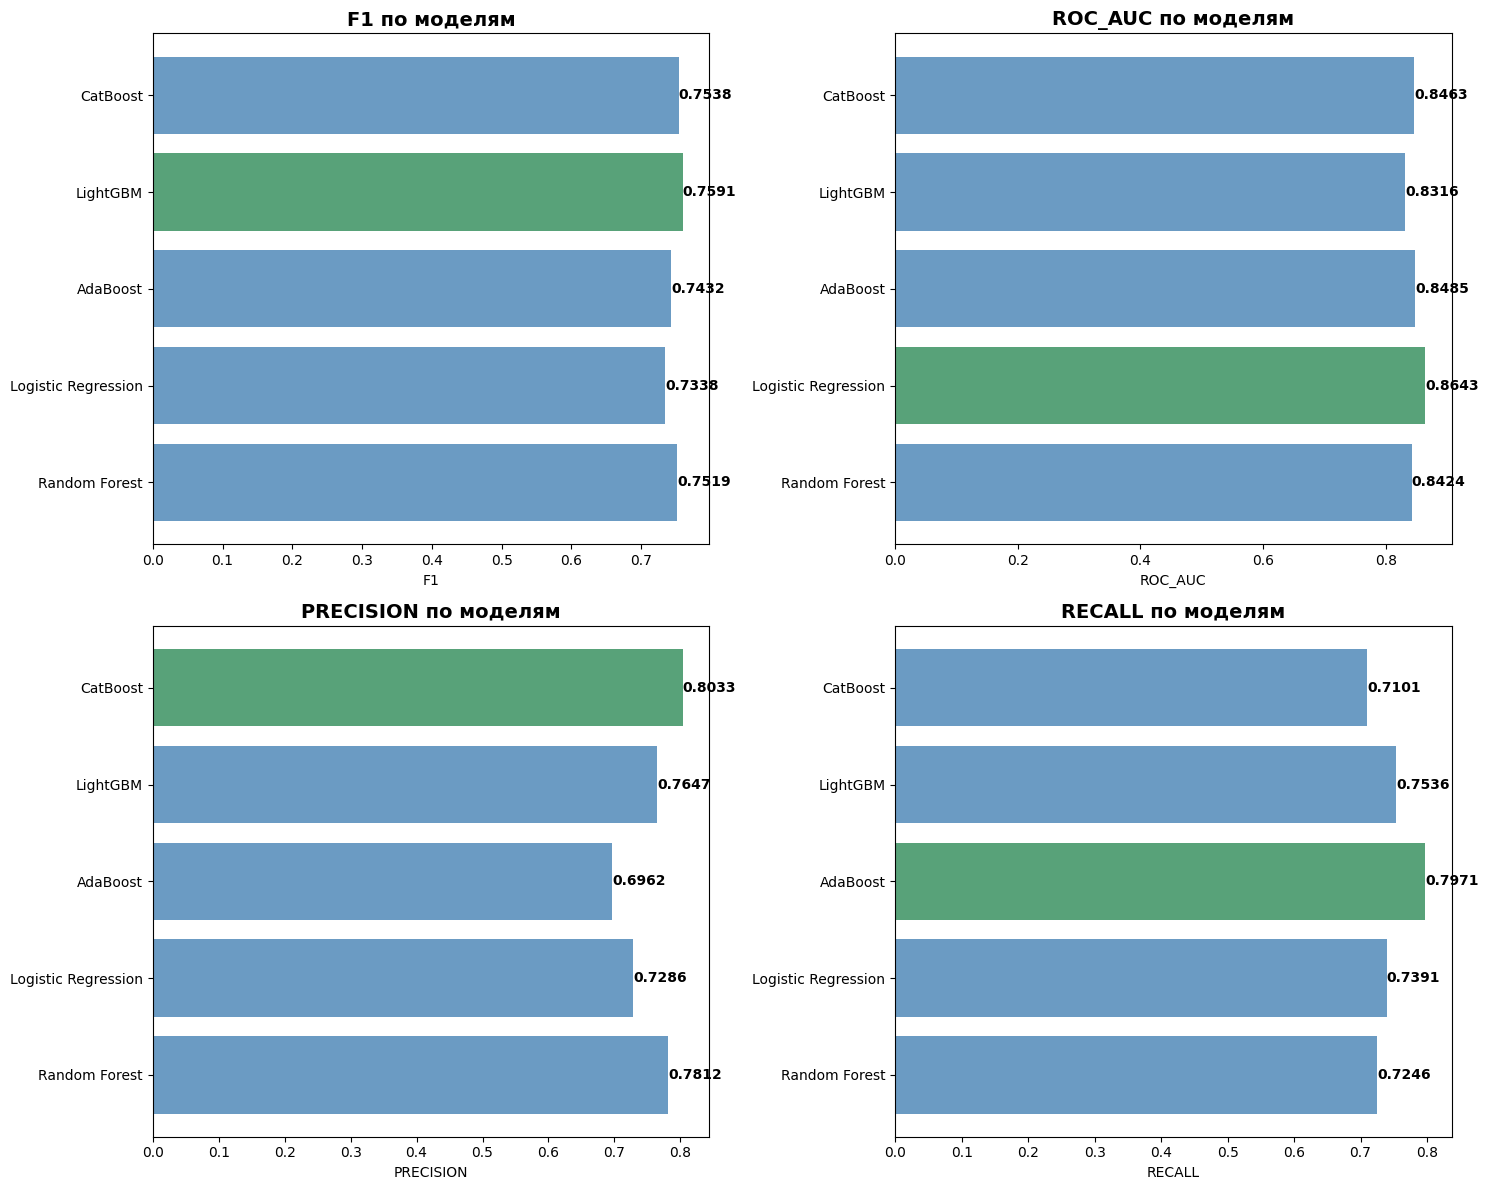

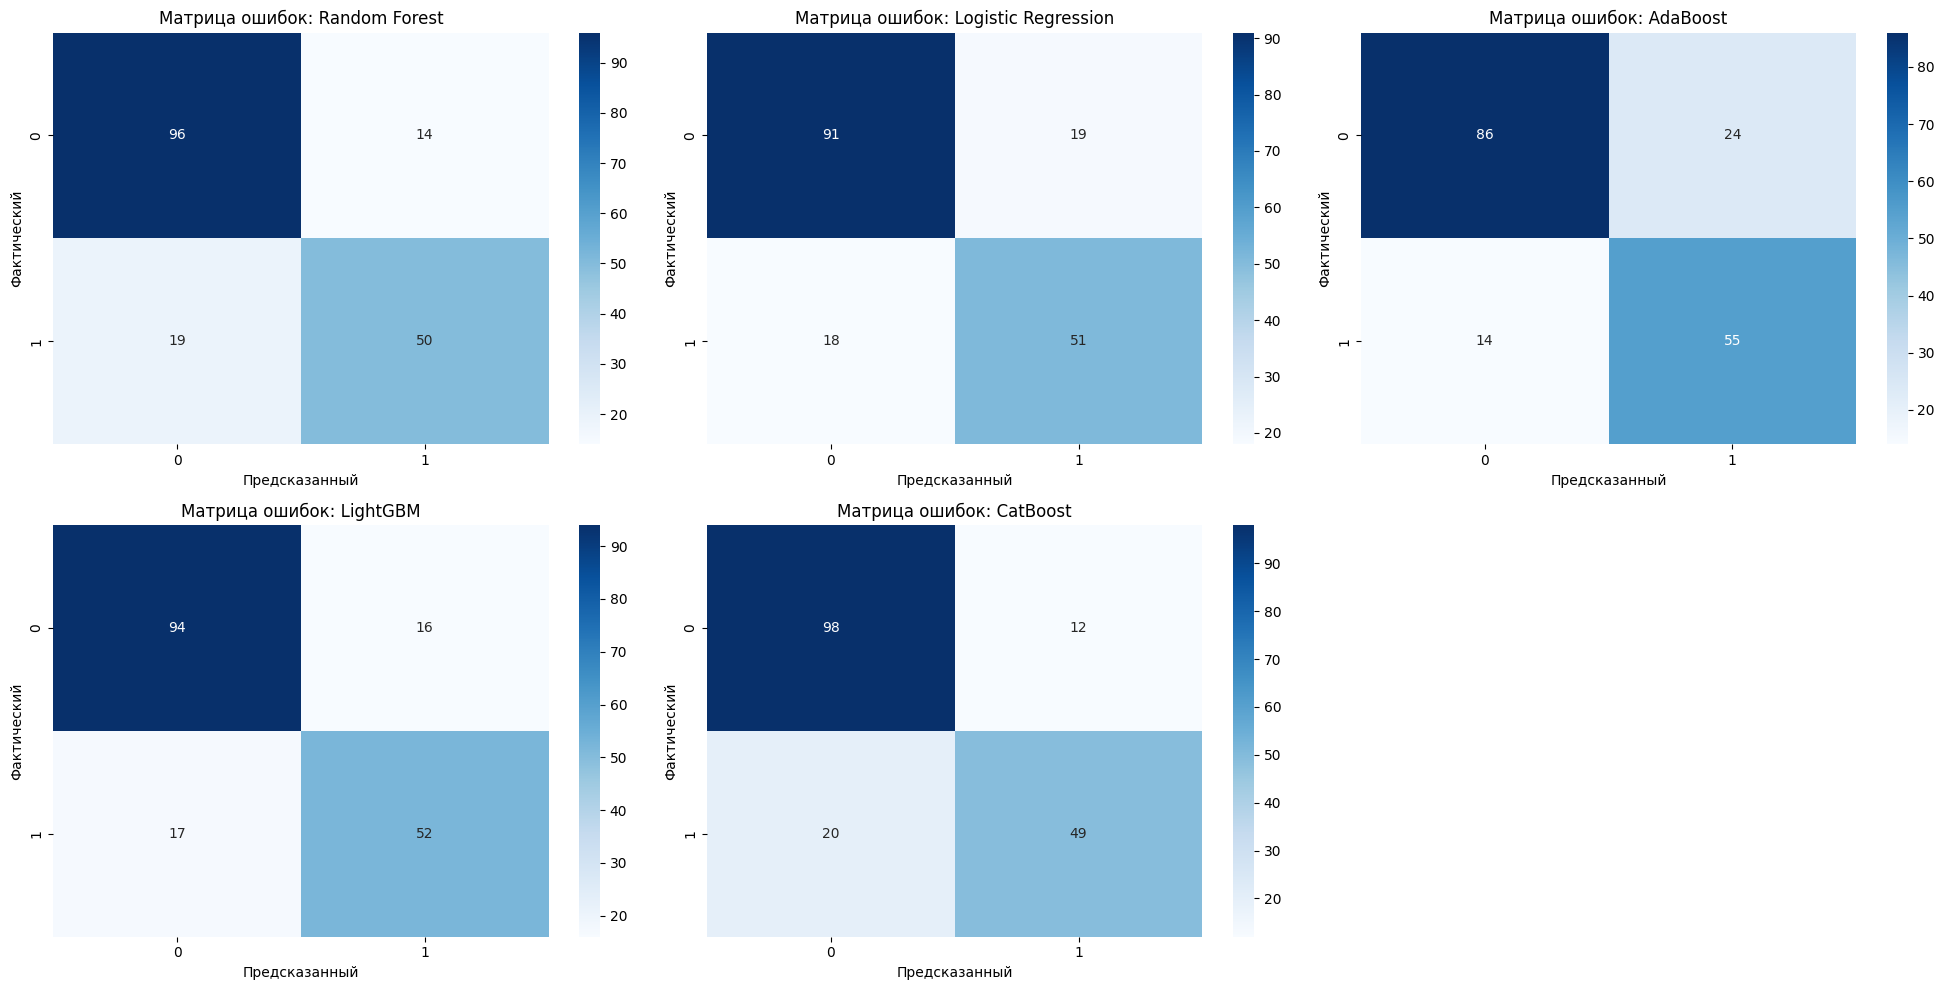


КОМПЛЕКСНЫЙ ОТЧЕТ (SMOTE)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод балансировки: smote
   Размер после балансировки: (878, 12)
   Финальный баланс: {1: 439, 0: 439}

ЛУЧШАЯ МОДЕЛЬ: CatBoost
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7538
   ROC-AUC:        0.8463
   Accuracy:       0.8212
   Precision:      0.8033
   Recall:         0.7101

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
           LightGBM  0.759124 0.831555   0.764706 0.753623  0.815642
           CatBoost  0.753846 0.846311   0.803279 0.710145  0.821229
      Random Forest  0.751880 0.842424   0.781250 0.724638  0.815642
           AdaBoost  0.743243 0.848485   0.696203 0.797101  0.787709
Logistic Regression  0.733813 0.864295   0.728571 0.739130  0.793296

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (Random Forest):
   Sex: 31.2%
   Fare: 16.0%
   Age: 12.7%
  

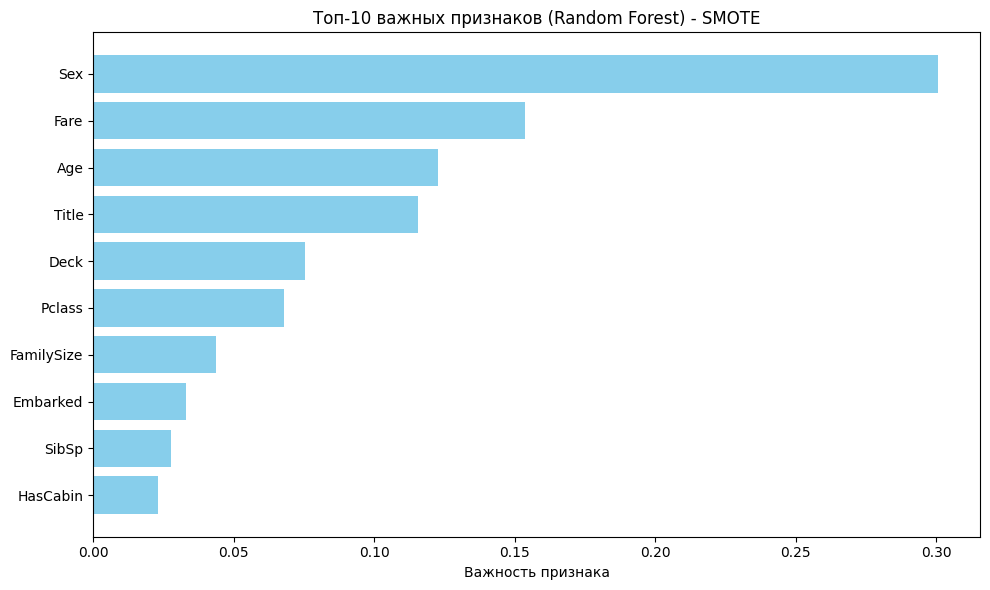


Тестирование метода: ADASYN
----------------------------------------
ЗАПУСК АНАЛИЗА TITANIC DATASET (ADASYN)
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
БАЛАНСИРОВКА ДАННЫХ (ADASYN):
   До балансировки: {0: 439, 1: 273}
   После балансировки: {1: 446, 0: 439}
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}
      Лучший F1: 0.8389
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 0.1}
      Лучший F1: 0.8063
   Подбор параметров для AdaBoost...
      Лучшие параметры: {'n_estimators': 200, 'learning_rate': 0.5, 'algorithm': 'SAMME'}
      Лучший F1: 0.8258
   Подбор параметров для LightGBM...
      Лучшие параметры: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
      Лучший F1: 0.8354
  

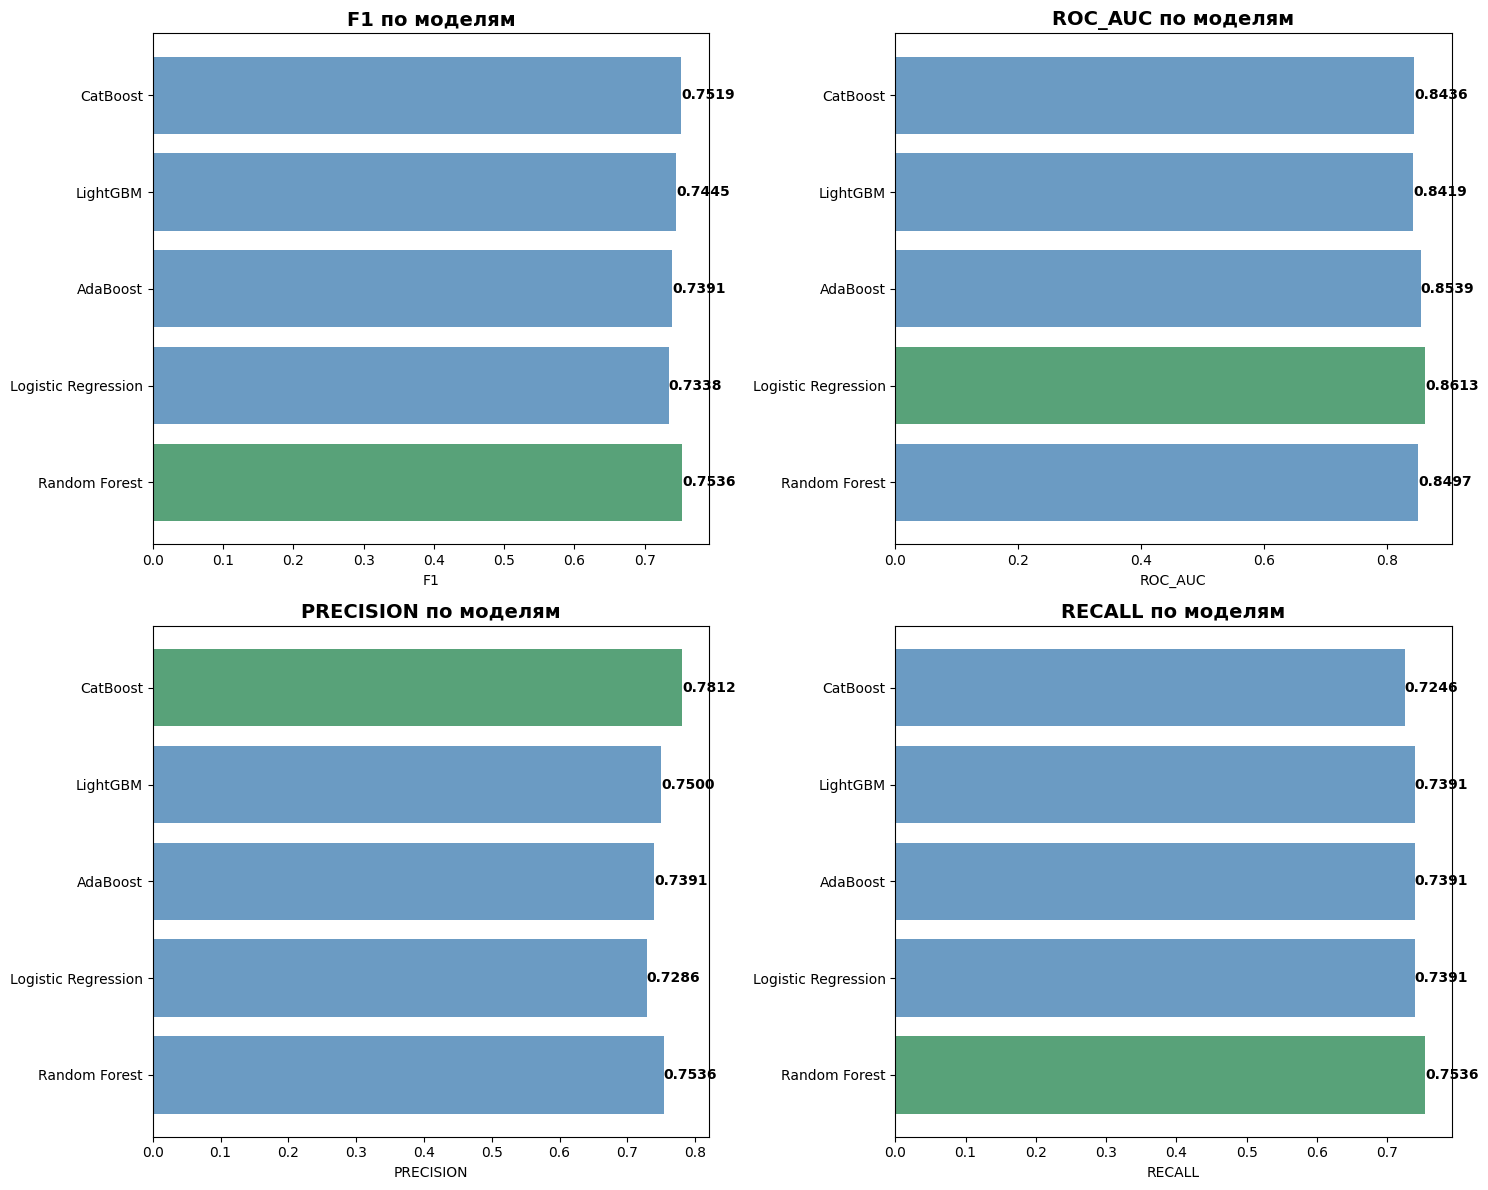

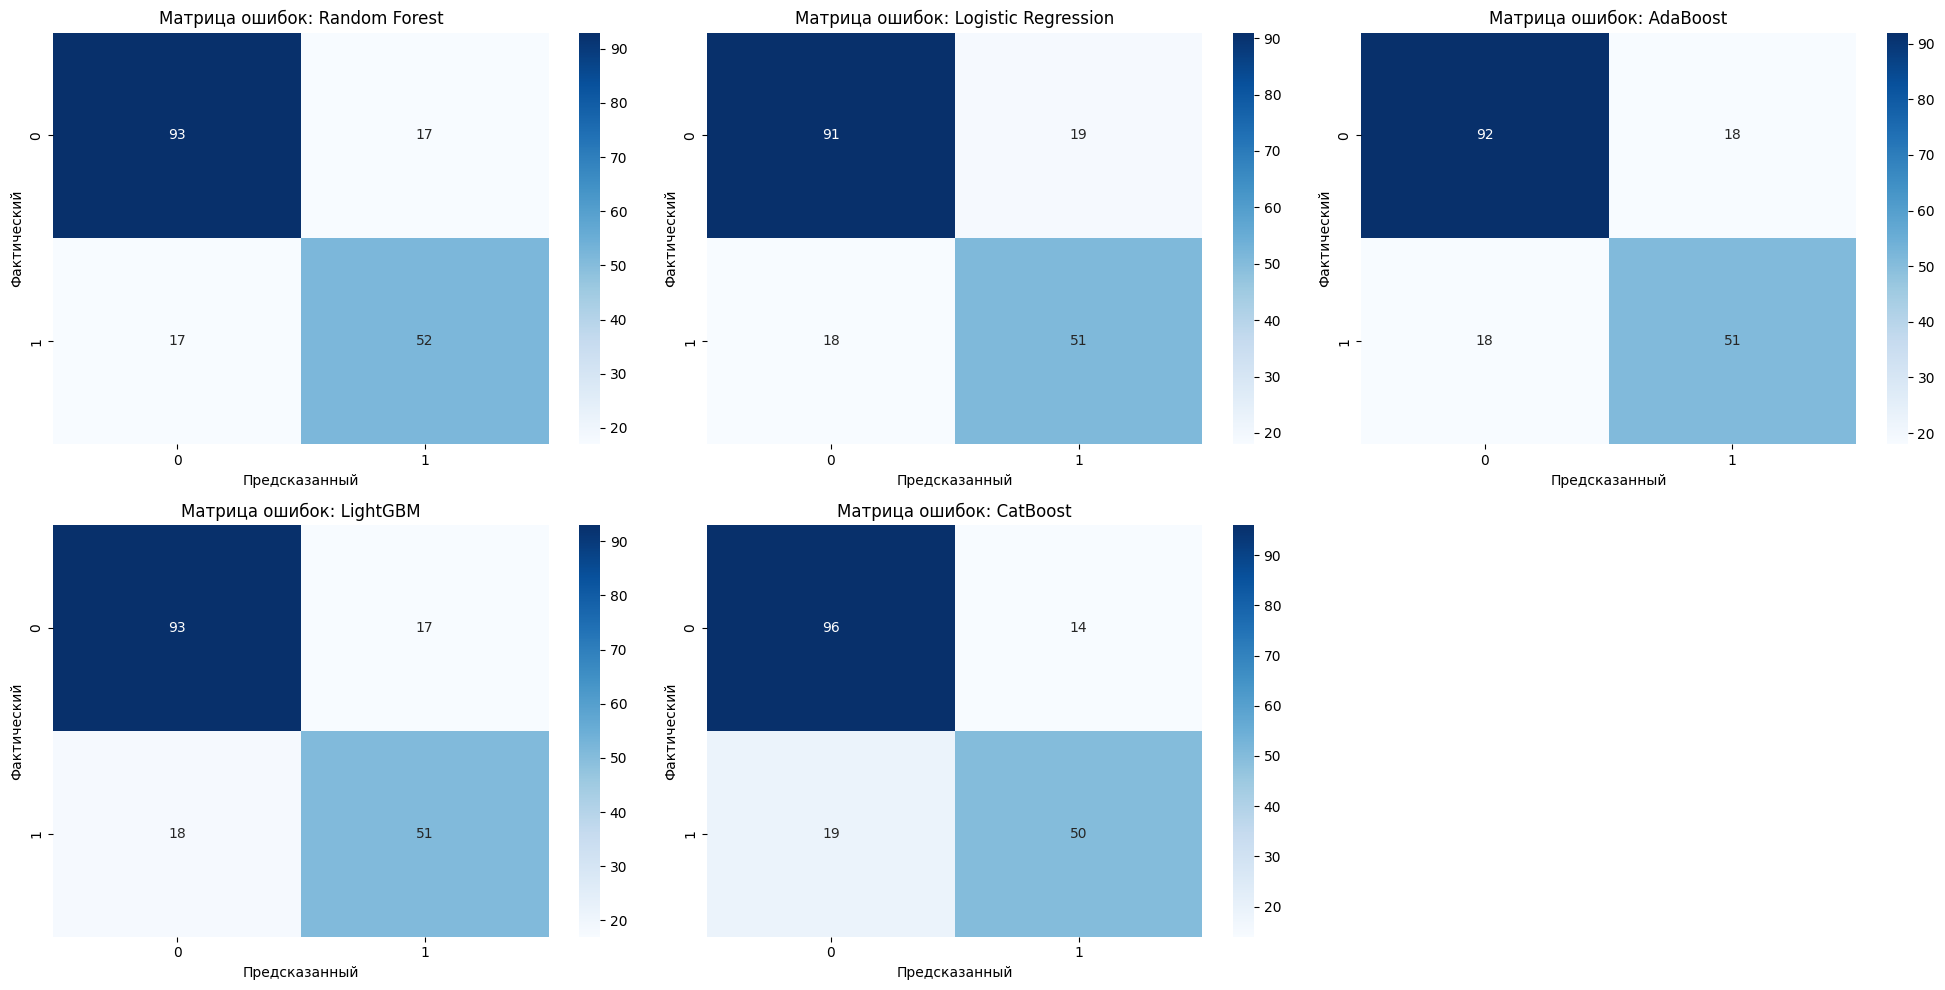


КОМПЛЕКСНЫЙ ОТЧЕТ (ADASYN)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод балансировки: adasyn
   Размер после балансировки: (885, 12)
   Финальный баланс: {1: 446, 0: 439}

ЛУЧШАЯ МОДЕЛЬ: Random Forest
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7536
   ROC-AUC:        0.8497
   Accuracy:       0.8101
   Precision:      0.7536
   Recall:         0.7536

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
      Random Forest  0.753623 0.849671   0.753623 0.753623  0.810056
           CatBoost  0.751880 0.843610   0.781250 0.724638  0.815642
           LightGBM  0.744526 0.841897   0.750000 0.739130  0.804469
           AdaBoost  0.739130 0.853887   0.739130 0.739130  0.798883
Logistic Regression  0.733813 0.861265   0.728571 0.739130  0.793296

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (Random Forest):


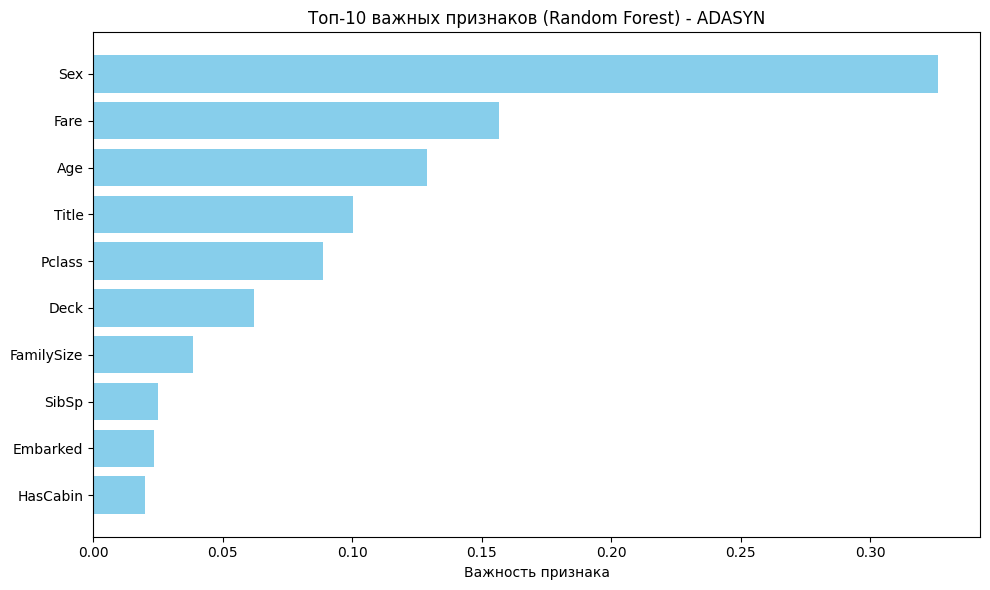


Тестирование метода: SMOTEENN
----------------------------------------
ЗАПУСК АНАЛИЗА TITANIC DATASET (SMOTEENN)
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
БАЛАНСИРОВКА ДАННЫХ (SMOTEENN):
   До балансировки: {0: 439, 1: 273}
   После балансировки: {1: 226, 0: 212}
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}
      Лучший F1: 0.9621
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 0.1}
      Лучший F1: 0.9401
   Подбор параметров для AdaBoost...
      Лучшие параметры: {'n_estimators': 200, 'learning_rate': 1, 'algorithm': 'SAMME'}
      Лучший F1: 0.9532
   Подбор параметров для LightGBM...
      Лучшие параметры: {'subsample': 0.9, 'num_leaves': 100, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
      Лучший F1: 0.96

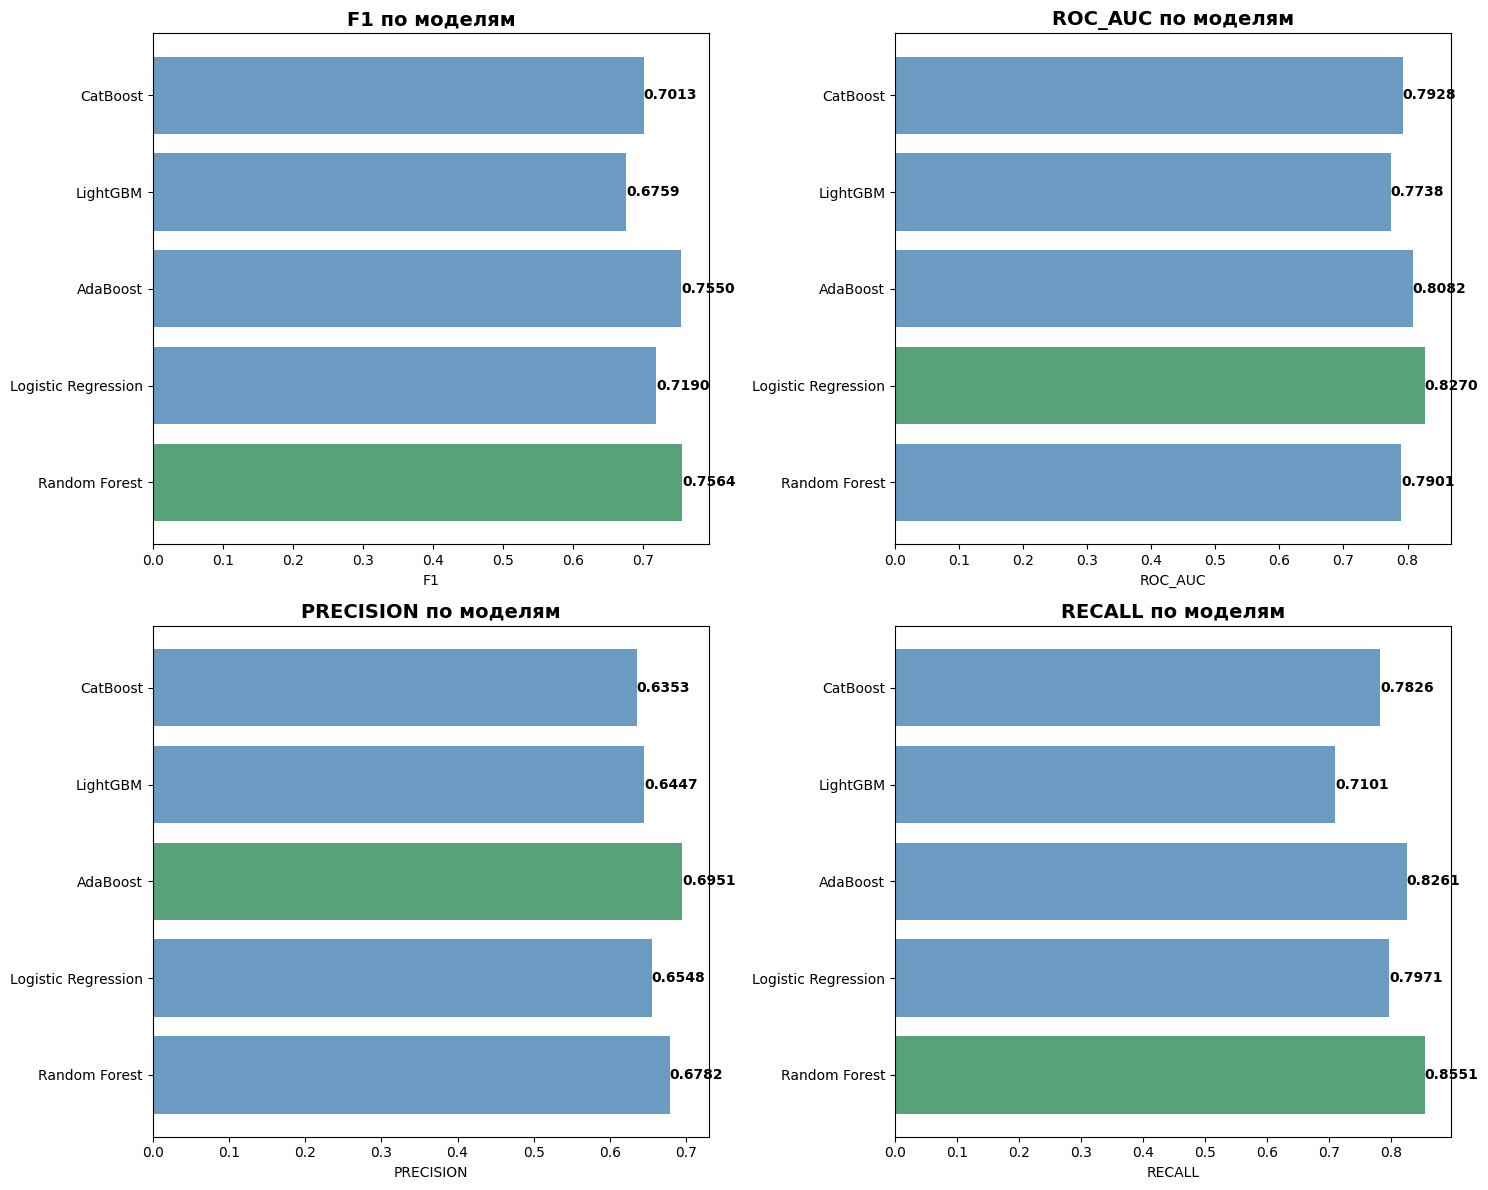

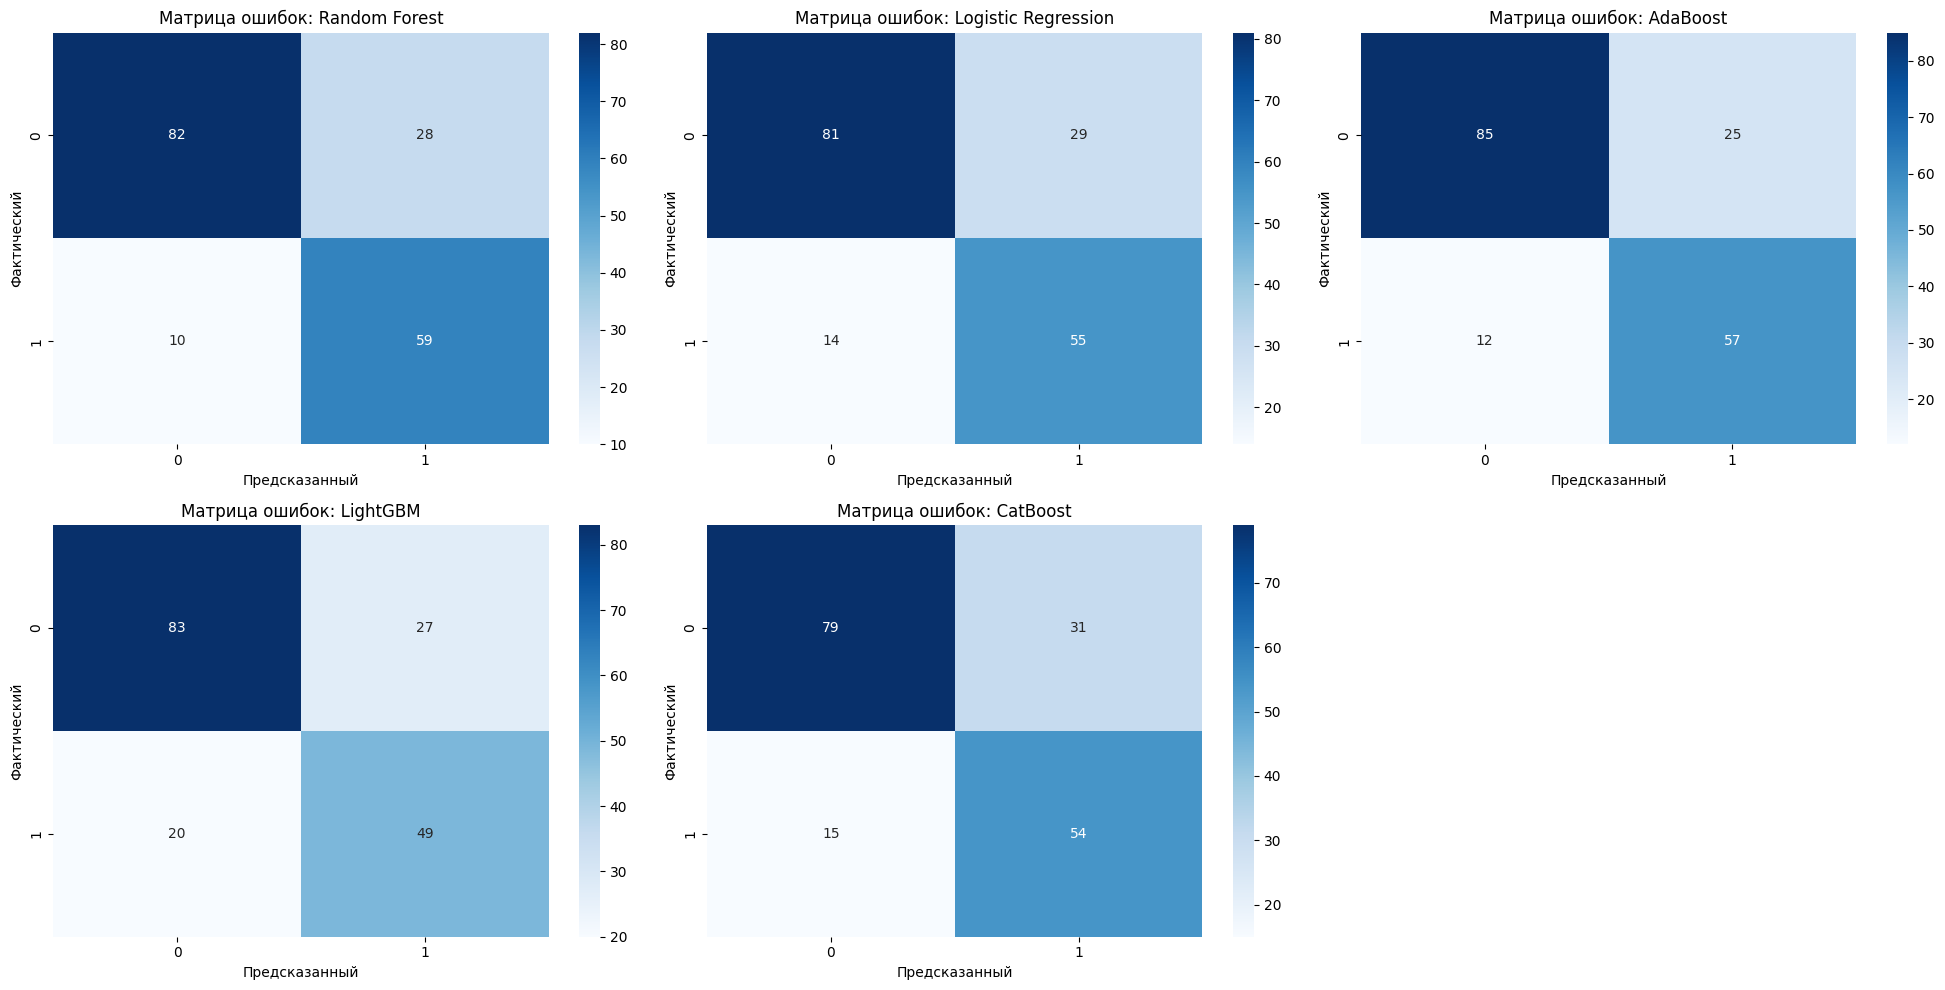


КОМПЛЕКСНЫЙ ОТЧЕТ (SMOTEENN)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод балансировки: smoteenn
   Размер после балансировки: (438, 12)
   Финальный баланс: {1: 226, 0: 212}

ЛУЧШАЯ МОДЕЛЬ: AdaBoost
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   AdaBoost: {'n_estimators': 200, 'learning_rate': 1, 'algorithm': 'SAMME'}

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7550
   ROC-AUC:        0.8082
   Accuracy:       0.7933
   Precision:      0.6951
   Recall:         0.8261

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
      Random Forest  0.756410 0.790119   0.678161 0.855072  0.787709
           AdaBoost  0.754967 0.808169   0.695122 0.826087  0.793296
Logistic Regression  0.718954 0.827009   0.654762 0.797101  0.759777
           CatBoost  0.701299 0.792754   0.635294 0.782609  0.743017
           LightGBM  0.675862 0.773847   0.644737 0.710145  0.737430

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (Random Forest):
   Sex: 30.3%
   Title: 13.9%
   Fare: 12.8%
   

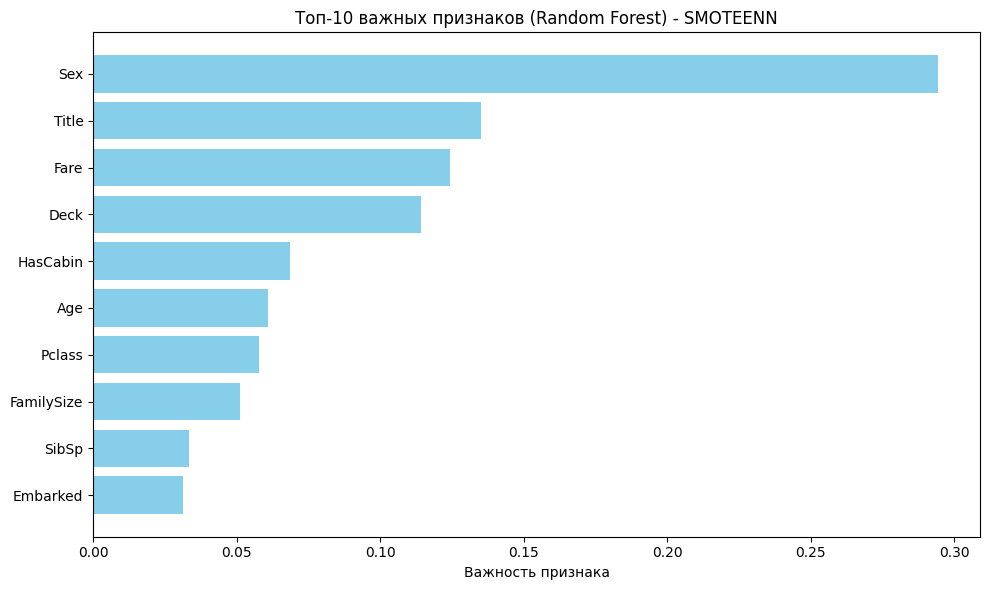


Тестирование метода: NONE
----------------------------------------
ЗАПУСК АНАЛИЗА TITANIC DATASET (NONE)
РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ
БАЛАНСИРОВКА ДАННЫХ (NONE):
   До балансировки: {0: 439, 1: 273}
   После балансировки: {0: 439, 1: 273}
ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...
   Подбор параметров для Random Forest...
      Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'bootstrap': True}
      Лучший F1: 0.7665
   Подбор параметров для Logistic Regression...
      Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.5, 'C': 10}
      Лучший F1: 0.7420
   Подбор параметров для AdaBoost...
      Лучшие параметры: {'n_estimators': 200, 'learning_rate': 0.5, 'algorithm': 'SAMME'}
      Лучший F1: 0.7594
   Подбор параметров для LightGBM...
      Лучшие параметры: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
      Лучший F1: 0.7691
   Подбор

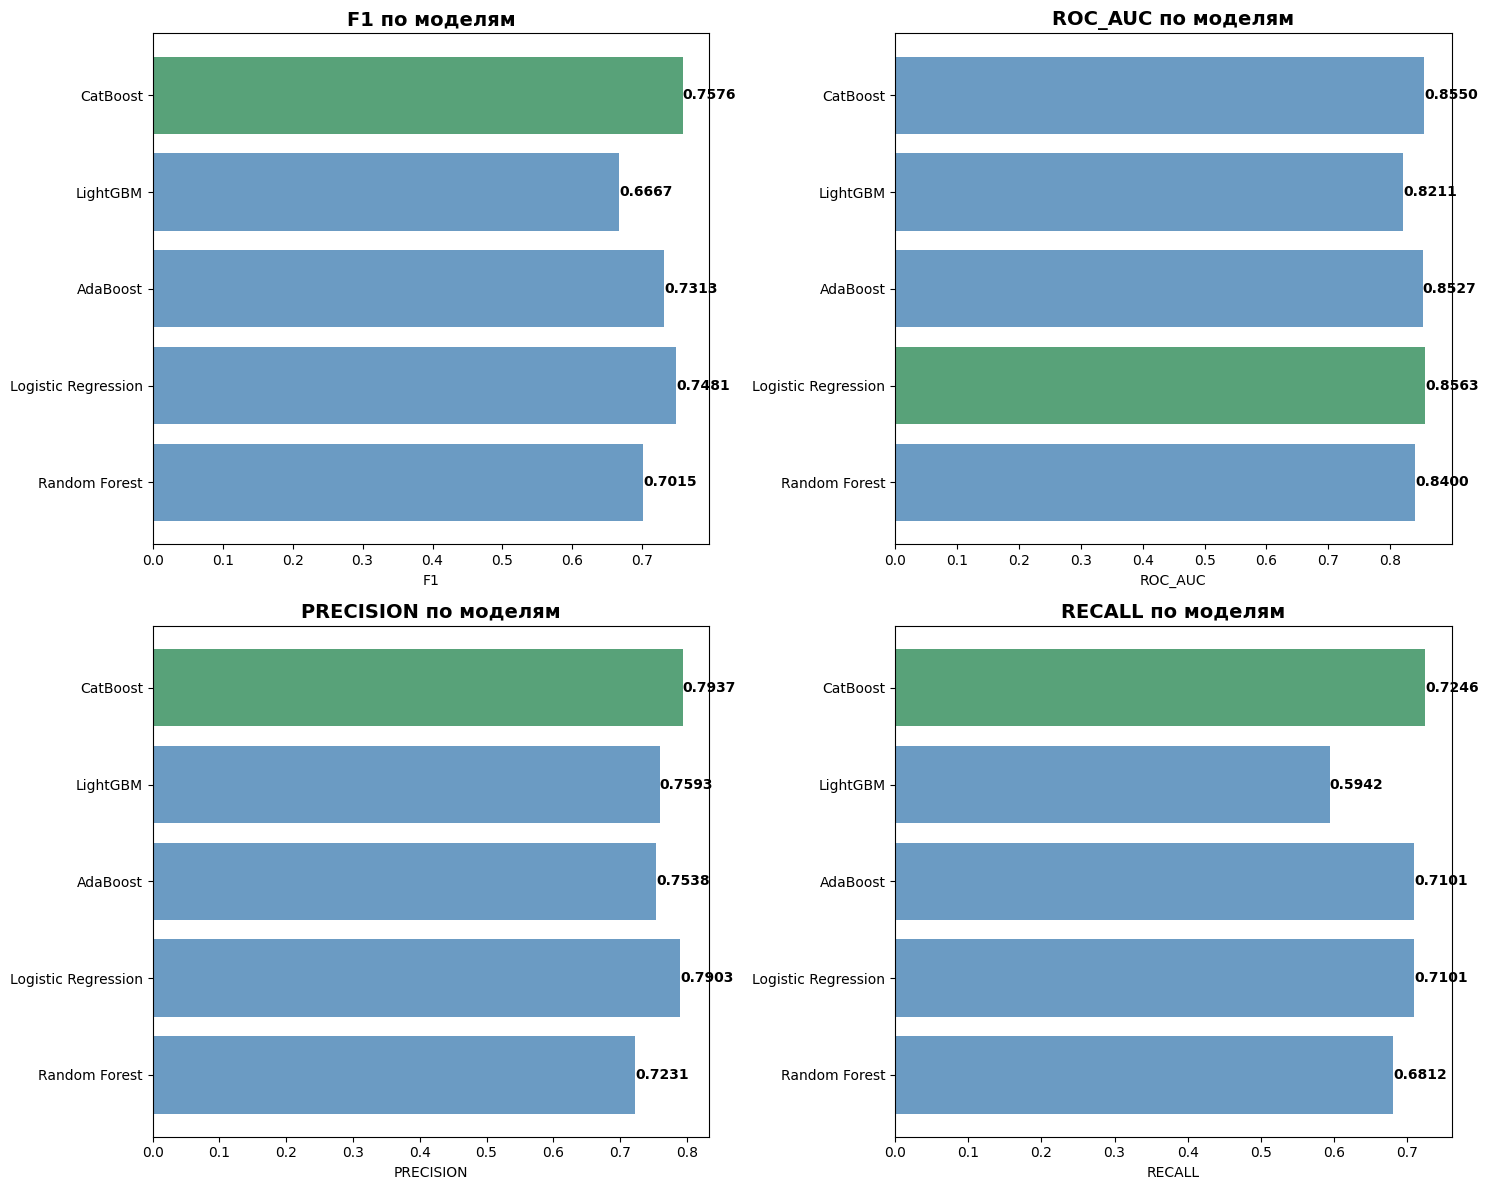

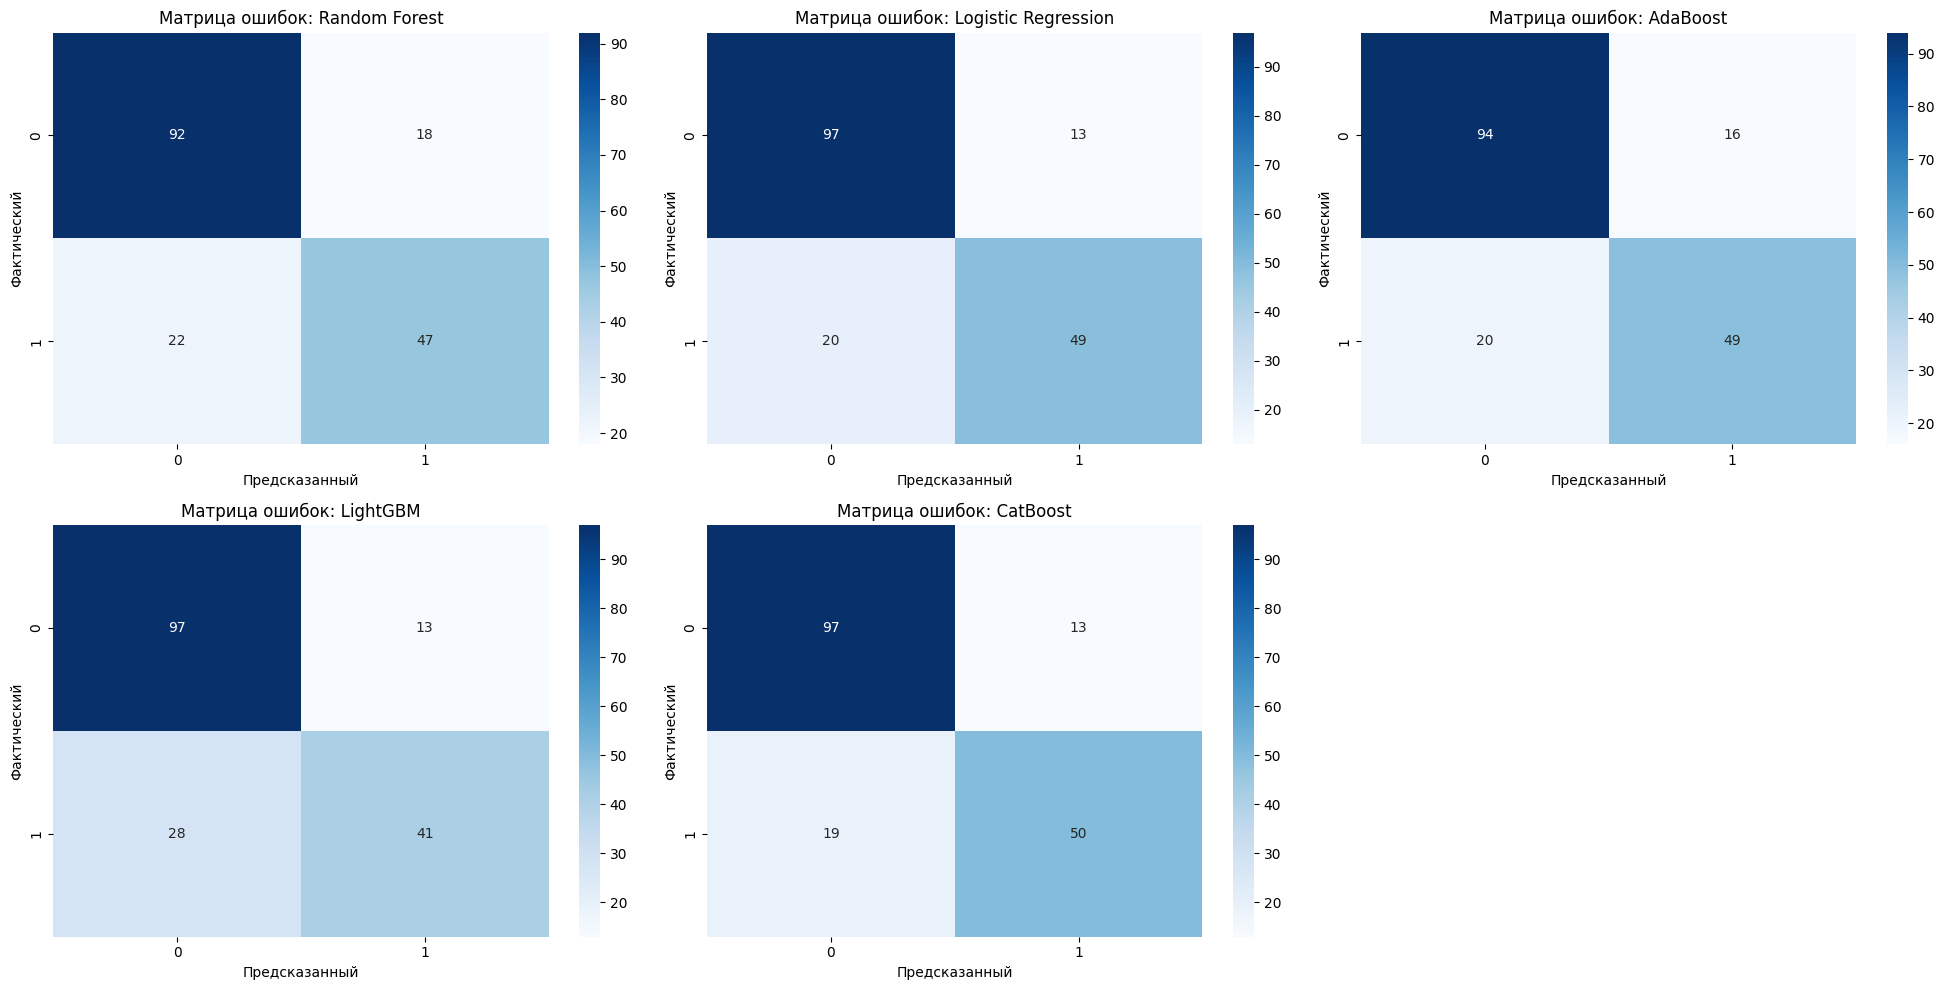


КОМПЛЕКСНЫЙ ОТЧЕТ (NONE)

ИНФОРМАЦИЯ О ДАННЫХ:
   Исходный размер: (891, 12)
   Метод балансировки: none
   Размер после балансировки: (712, 12)
   Финальный баланс: {0: 439, 1: 273}

ЛУЧШАЯ МОДЕЛЬ: CatBoost
ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
   CatBoost: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 4}

МЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:
   F1-Score:       0.7576
   ROC-AUC:        0.8550
   Accuracy:       0.8212
   Precision:      0.7937
   Recall:         0.7246

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  F1-Score  ROC-AUC  Precision   Recall  Accuracy
           CatBoost  0.757576 0.855007   0.793651 0.724638  0.821229
Logistic Regression  0.748092 0.856258   0.790323 0.710145  0.815642
           AdaBoost  0.731343 0.852701   0.753846 0.710145  0.798883
      Random Forest  0.701493 0.839987   0.723077 0.681159  0.776536
           LightGBM  0.666667 0.821146   0.759259 0.594203  0.770950

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ (Random Forest):
   Sex: 37.0%
   Title: 13.5%
   Fare: 11.0%
  

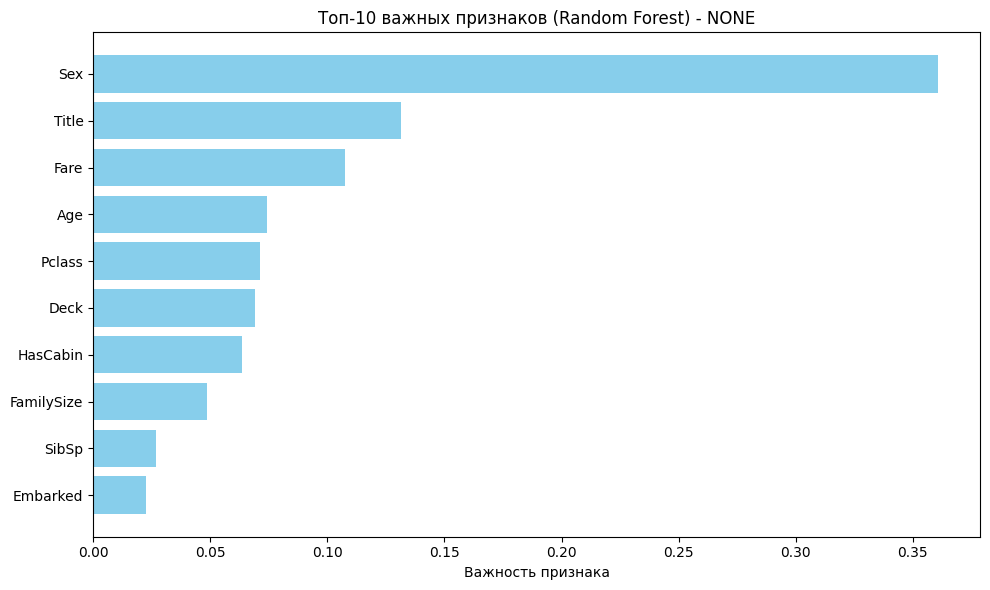

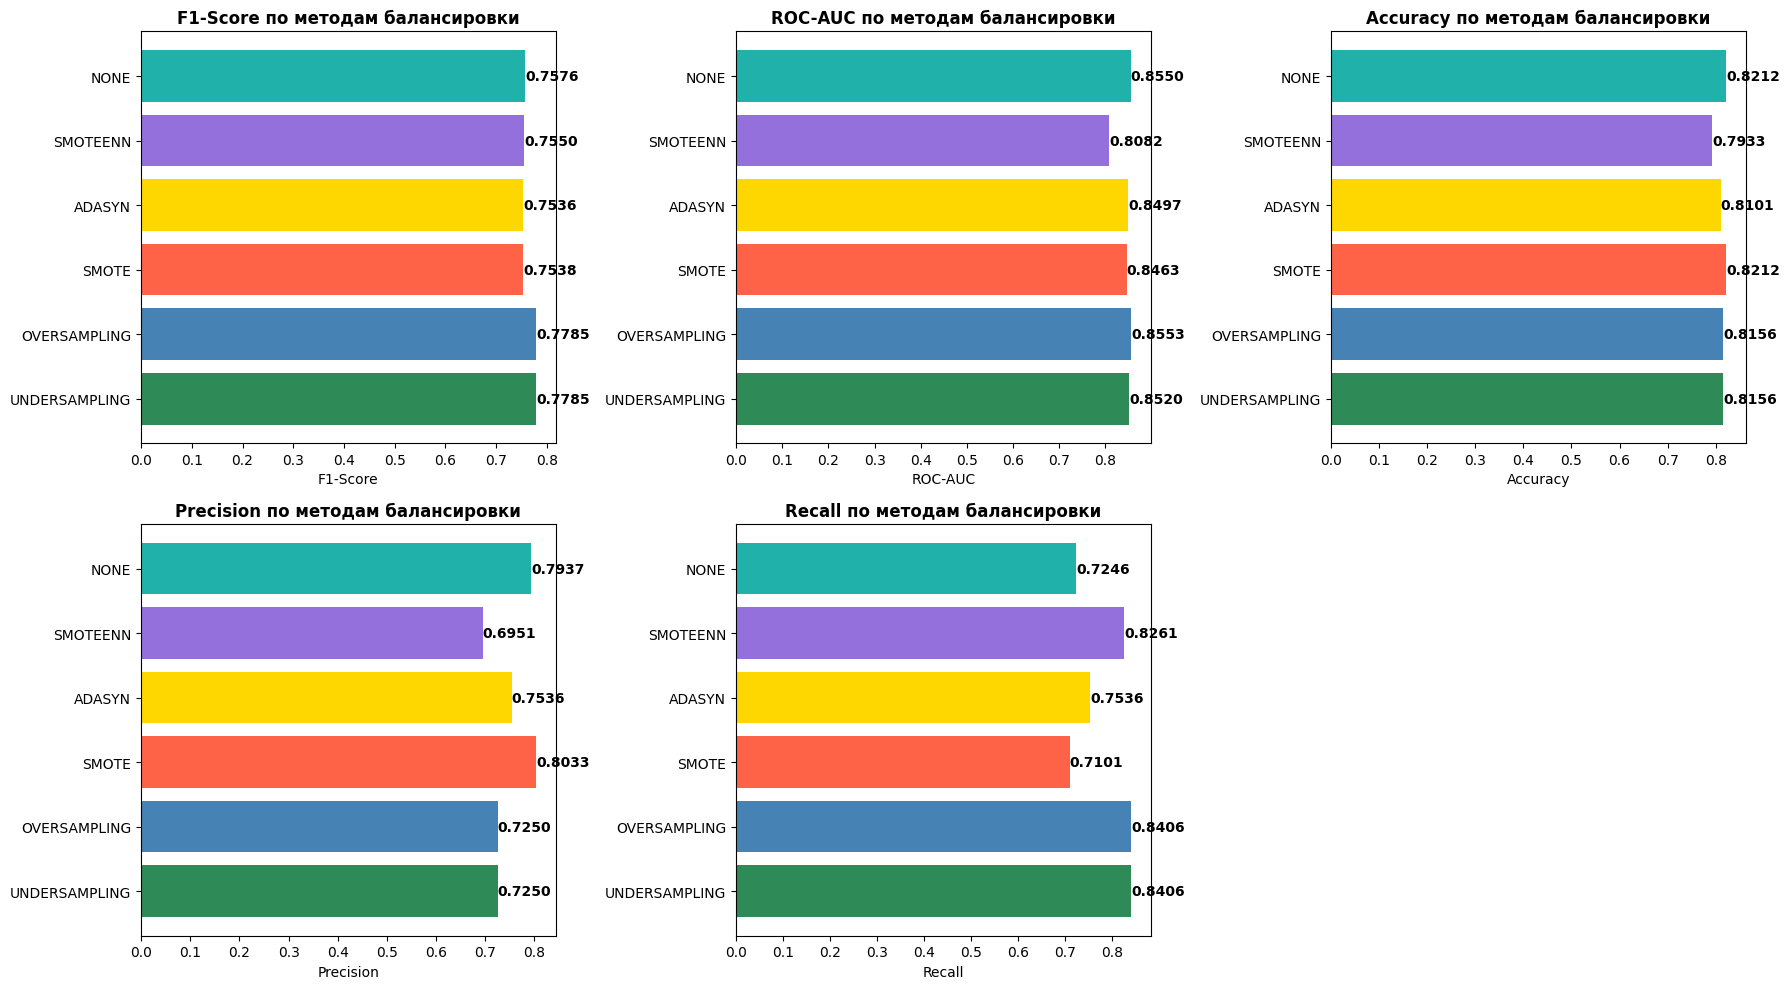


СРАВНЕНИЕ МЕТОДОВ БАЛАНСИРОВКИ
       Method    Best Model  F1-Score  ROC-AUC  Accuracy  Precision   Recall
UNDERSAMPLING      CatBoost  0.778523 0.851976  0.815642   0.725000 0.840580
 OVERSAMPLING      AdaBoost  0.778523 0.855270  0.815642   0.725000 0.840580
        SMOTE      CatBoost  0.753846 0.846311  0.821229   0.803279 0.710145
       ADASYN Random Forest  0.753623 0.849671  0.810056   0.753623 0.753623
     SMOTEENN      AdaBoost  0.754967 0.808169  0.793296   0.695122 0.826087
         NONE      CatBoost  0.757576 0.855007  0.821229   0.793651 0.724638

ЛУЧШИЙ МЕТОД БАЛАНСИРОВКИ: UNDERSAMPLING
   F1-Score: 0.7785
   ROC-AUC: 0.8520
   Лучшая модель: CatBoost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings('ignore')

# Проверяем наличие lightgbm и импортируем
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    print("LightGBM не установлен. Установите: pip install lightgbm")
    LGBM_AVAILABLE = False

# Проверяем наличие catboost и импортируем
try:
    import catboost as cb
    CATBOOST_AVAILABLE = True
except ImportError:
    print("CatBoost не установлен. Установите: pip install catboost")
    CATBOOST_AVAILABLE = False

class SmartTitanicPredictor:
    def __init__(self, use_hyperparameter_tuning=True):
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}
        self.balancing_results = {}
        self.feature_names = []
        self.original_shape = None
        self.balancing_method = None
        self.X_test = None
        self.y_test = None
        self.use_hyperparameter_tuning = use_hyperparameter_tuning
        self.best_params = {}
        
    def load_and_preprocess_data(self, file_path):
        """Загрузка и предварительная обработка данных"""
        data = pd.read_csv(file_path)
        self.original_shape = data.shape
        
        df = data.copy()
        
        df['Age'].fillna(df['Age'].median(), inplace=True)
        df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
        df['Fare'].fillna(df['Fare'].median(), inplace=True)
        
        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 
                                          'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dana'], 'Rare')
        df['Title'] = df['Title'].replace('Mlle', 'Miss')
        df['Title'] = df['Title'].replace('Ms', 'Miss')
        df['Title'] = df['Title'].replace('Mme', 'Mrs')
        
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = 0
        df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
        
        df['Deck'] = df['Cabin'].str[0]
        df['Deck'] = df['Deck'].fillna('U')
        df['HasCabin'] = df['Cabin'].notna().astype(int)
        
        label_encoders = {}
        categorical_cols = ['Sex', 'Embarked', 'Title', 'Deck']
        
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
        
        features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                   'Embarked', 'Title', 'FamilySize', 'IsAlone', 'HasCabin', 'Deck']
        
        X = df[features]
        y = df['Survived']
        
        self.feature_names = features
        return X, y, df
    
    def balance_data(self, X, y, method='undersampling'):
        """Балансировка данных различными методами"""
        balancing_methods = {
            'undersampling': RandomUnderSampler(random_state=42),
            'oversampling': RandomOverSampler(random_state=42),
            'smote': SMOTE(random_state=42),
            'adasyn': ADASYN(random_state=42),
            'smoteenn': SMOTEENN(random_state=42),
            'none': None
        }
        
        if method not in balancing_methods:
            raise ValueError(f"Метод {method} не поддерживается. Доступные методы: {list(balancing_methods.keys())}")
        
        if method == 'none':
            X_balanced, y_balanced = X, y
        else:
            sampler = balancing_methods[method]
            X_balanced, y_balanced = sampler.fit_resample(X, y)
        
        self.balancing_method = method
        
        print(f"БАЛАНСИРОВКА ДАННЫХ ({method.upper()}):")
        print(f"   До балансировки: {pd.Series(y).value_counts().to_dict()}")
        print(f"   После балансировки: {pd.Series(y_balanced).value_counts().to_dict()}")
        
        return X_balanced, y_balanced
    
    def create_optimized_models(self):
        """Создание моделей с настройками по умолчанию"""
        self.models = {
            'Random Forest': RandomForestClassifier(random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'AdaBoost': AdaBoostClassifier(random_state=42)
        }
        
        if LGBM_AVAILABLE:
            self.models['LightGBM'] = lgb.LGBMClassifier(random_state=42, verbose=-1)
            
        if CATBOOST_AVAILABLE:
            self.models['CatBoost'] = cb.CatBoostClassifier(random_state=42, verbose=False)
    
    def hyperparameter_tuning(self, X_train, y_train):
        """Динамический подбор гиперпараметров для моделей"""
        print("ЗАПУСК ПОДБОРА ГИПЕРПАРАМЕТРОВ...")
        
        param_grids = {
            'Random Forest': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 15, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            },
            'Logistic Regression': {
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'solver': ['liblinear', 'lbfgs'],
                'penalty': ['l1', 'l2', 'elasticnet'],
                'l1_ratio': [0.1, 0.5, 0.9]
            },
            'AdaBoost': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.5, 1],
                'algorithm': ['SAMME', 'SAMME.R']
            }
        }
        
        if LGBM_AVAILABLE:
            param_grids['LightGBM'] = {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7, -1],
                'num_leaves': [31, 50, 100],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0]
            }
            
        if CATBOOST_AVAILABLE:
            param_grids['CatBoost'] = {
                'iterations': [100, 200, 300],
                'learning_rate': [0.01, 0.05, 0.1],
                'depth': [4, 6, 8],
                'l2_leaf_reg': [1, 3, 5]
            }
        
        tuned_models = {}
        
        for name, model in self.models.items():
            print(f"   Подбор параметров для {name}...")
            
            try:
                if name in param_grids:
                    search = RandomizedSearchCV(
                        model, 
                        param_grids[name], 
                        n_iter=20,
                        cv=3,
                        scoring='f1',
                        n_jobs=-1,
                        random_state=42,
                        verbose=0
                    )
                    
                    search.fit(X_train, y_train)
                    
                    tuned_models[name] = search.best_estimator_
                    self.best_params[name] = search.best_params_
                    
                    print(f"      Лучшие параметры: {search.best_params_}")
                    print(f"      Лучший F1: {search.best_score_:.4f}")
                else:
                    tuned_models[name] = model
                    self.best_params[name] = "По умолчанию"
                    print(f"      Используются параметры по умолчанию")
                    
            except Exception as e:
                print(f"      Ошибка при подборе параметров для {name}: {e}")
                tuned_models[name] = model
                self.best_params[name] = "По умолчанию (ошибка)"
        
        return tuned_models
    
    def optimize_and_train(self, X_train, X_test, y_train, y_test):
        """Обучение и оптимизация моделей"""
        if self.use_hyperparameter_tuning:
            tuned_models = self.hyperparameter_tuning(X_train, y_train)
        else:
            tuned_models = self.models
            for name in tuned_models.keys():
                self.best_params[name] = "Без подбора"
        
        print("\nОБУЧЕНИЕ МОДЕЛЕЙ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ...")
        
        for name, model in tuned_models.items():
            print(f"Обучение {name}...")
            
            try:
                if not hasattr(model, 'fitted_') or not model.fitted_:
                    model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                
                f1 = f1_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                accuracy = model.score(X_test, y_test)
                
                cm = confusion_matrix(y_test, y_pred)
                tn, fp, fn, tp = cm.ravel()
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                
                feature_importance = None
                if hasattr(model, 'feature_importances_'):
                    feature_importance = model.feature_importances_
                elif hasattr(model, 'coef_'):
                    feature_importance = np.abs(model.coef_[0])
                
                self.results[name] = {
                    'f1': f1,
                    'roc_auc': roc_auc,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'feature_importance': feature_importance,
                    'model': model
                }
                
                print(f"   F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
                
            except Exception as e:
                print(f"   Ошибка при обучении {name}: {e}")
    
    def run_complete_analysis(self, file_path, balancing_method='undersampling'):
        """Запуск полного анализа с указанным методом балансировки"""
        print(f"ЗАПУСК АНАЛИЗА TITANIC DATASET ({balancing_method.upper()})")
        if self.use_hyperparameter_tuning:
            print("РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ")
        else:
            print("РЕЖИМ: БЕЗ ПОДБОРА ГИПЕРПАРАМЕТРОВ")
        print("=" * 60)
        
        X, y, processed_df = self.load_and_preprocess_data(file_path)
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        self.X_test = X_test
        self.y_test = y_test
        
        X_train_balanced, y_train_balanced = self.balance_data(X_train, y_train, method=balancing_method)
        
        X_train_scaled = self.scaler.fit_transform(X_train_balanced)
        X_test_scaled = self.scaler.transform(X_test)
        
        self.create_optimized_models()
        self.optimize_and_train(X_train_scaled, X_test_scaled, y_train_balanced, y_test)
        
        self.balancing_results[balancing_method] = {
            'results': self.results.copy(),
            'best_model': max(self.results.items(), key=lambda x: x[1]['f1'] + x[1]['roc_auc'])[0] if self.results else None
        }
        
        self.visualize_results()
        self.generate_comprehensive_report(X_train_balanced, y_train_balanced, balancing_method)
        
        return self.results
    
    def compare_balancing_methods(self, file_path):
        """Сравнение различных методов балансировки"""
        methods = ['undersampling', 'oversampling', 'smote', 'adasyn', 'smoteenn', 'none']
        comparison_data = []
        
        print("СРАВНЕНИЕ МЕТОДОВ БАЛАНСИРОВКИ")
        if self.use_hyperparameter_tuning:
            print("РЕЖИМ: С ПОДБОРОМ ГИПЕРПАРАМЕТРОВ")
        print("=" * 60)
        
        for method in methods:
            print(f"\nТестирование метода: {method.upper()}")
            print("-" * 40)
            
            results = self.run_complete_analysis(file_path, balancing_method=method)
            
            if results:
                best_model_name = max(results.items(), key=lambda x: x[1]['f1'] + x[1]['roc_auc'])[0]
                best_result = results[best_model_name]
                
                comparison_data.append({
                    'Method': method.upper(),
                    'Best Model': best_model_name,
                    'F1-Score': best_result['f1'],
                    'ROC-AUC': best_result['roc_auc'],
                    'Accuracy': best_result['accuracy'],
                    'Precision': best_result['precision'],
                    'Recall': best_result['recall']
                })
        
        self.visualize_balancing_comparison(comparison_data)
        
        return comparison_data
    
    def visualize_balancing_comparison(self, comparison_data):
        """Визуализация сравнения методов балансировки"""
        if not comparison_data:
            return
            
        df_comparison = pd.DataFrame(comparison_data)
        
        metrics = ['F1-Score', 'ROC-AUC', 'Accuracy', 'Precision', 'Recall']
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.ravel()
        
        for i, metric in enumerate(metrics):
            if i < len(axes):
                bars = axes[i].barh(df_comparison['Method'], df_comparison[metric], 
                                  color=['#2E8B57', '#4682B4', '#FF6347', '#FFD700', '#9370DB', '#20B2AA'])
                axes[i].set_title(f'{metric} по методам балансировки', fontsize=12, fontweight='bold')
                axes[i].set_xlabel(metric)
                
                for bar, value in zip(bars, df_comparison[metric]):
                    axes[i].text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                               f'{value:.4f}', ha='left', va='center', fontweight='bold')
        
        if len(metrics) < len(axes):
            for i in range(len(metrics), len(axes)):
                axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "=" * 80)
        print("СРАВНЕНИЕ МЕТОДОВ БАЛАНСИРОВКИ")
        print("=" * 80)
        print(df_comparison.to_string(index=False))
        
        best_method = df_comparison.loc[df_comparison['F1-Score'].idxmax()]
        print(f"\nЛУЧШИЙ МЕТОД БАЛАНСИРОВКИ: {best_method['Method']}")
        print(f"   F1-Score: {best_method['F1-Score']:.4f}")
        print(f"   ROC-AUC: {best_method['ROC-AUC']:.4f}")
        print(f"   Лучшая модель: {best_method['Best Model']}")
    
    def visualize_results(self):
        """Визуализация результатов"""
        if not self.results:
            return
            
        models = list(self.results.keys())
        metrics = ['f1', 'roc_auc', 'precision', 'recall']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
        
        for i, metric in enumerate(metrics):
            values = [self.results[model][metric] for model in models]
            colors = ['#2E8B57' if x == max(values) else '#4682B4' for x in values]
            bars = axes[i].barh(models, values, color=colors, alpha=0.8)
            axes[i].set_title(f'{metric.upper()} по моделям', fontsize=14, fontweight='bold')
            axes[i].set_xlabel(metric.upper())
            
            for bar, value in zip(bars, values):
                axes[i].text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                           f'{value:.4f}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        if self.X_test is not None and self.y_test is not None:
            fig, axes = plt.subplots(2, 3, figsize=(20, 10))
            axes = axes.ravel()
            
            for idx, (name, result) in enumerate(self.results.items()):
                if idx >= 6:
                    break
                model = result['model']
                X_test_scaled = self.scaler.transform(self.X_test)
                y_pred = model.predict(X_test_scaled)
                cm = confusion_matrix(self.y_test, y_pred)
                
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
                axes[idx].set_title(f'Матрица ошибок: {name}', fontsize=12)
                axes[idx].set_xlabel('Предсказанный')
                axes[idx].set_ylabel('Фактический')
            
            for idx in range(len(self.results), 6):
                axes[idx].set_visible(False)
            
            plt.tight_layout()
            plt.show()
    
    def generate_comprehensive_report(self, X_balanced, y_balanced, balancing_method):
        """Генерация комплексного отчета"""
        if not self.results:
            return
            
        best_model_name = max(self.results.items(), 
                            key=lambda x: x[1]['f1'] + x[1]['roc_auc'])[0]
        best_result = self.results[best_model_name]
        
        print("\n" + "=" * 80)
        print(f"КОМПЛЕКСНЫЙ ОТЧЕТ ({balancing_method.upper()})")
        print("=" * 80)
        
        print(f"\nИНФОРМАЦИЯ О ДАННЫХ:")
        print(f"   Исходный размер: {self.original_shape}")
        print(f"   Метод балансировки: {balancing_method}")
        print(f"   Размер после балансировки: {X_balanced.shape}")
        print(f"   Финальный баланс: {pd.Series(y_balanced).value_counts().to_dict()}")
        
        print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
        print("=" * 50)
        
        print(f"ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
        for model_name, params in self.best_params.items():
            if model_name == best_model_name:
                print(f"   {model_name}: {params}")
        
        print(f"\nМЕТРИКИ ПРОИЗВОДИТЕЛЬНОСТИ:")
        print(f"   F1-Score:       {best_result['f1']:.4f}")
        print(f"   ROC-AUC:        {best_result['roc_auc']:.4f}")
        print(f"   Accuracy:       {best_result['accuracy']:.4f}")
        print(f"   Precision:      {best_result['precision']:.4f}")
        print(f"   Recall:         {best_result['recall']:.4f}")
        
        print(f"\nСРАВНЕНИЕ МОДЕЛЕЙ:")
        comparison_df = pd.DataFrame({
            'Model': list(self.results.keys()),
            'F1-Score': [self.results[m]['f1'] for m in self.results],
            'ROC-AUC': [self.results[m]['roc_auc'] for m in self.results],
            'Precision': [self.results[m]['precision'] for m in self.results],
            'Recall': [self.results[m]['recall'] for m in self.results],
            'Accuracy': [self.results[m]['accuracy'] for m in self.results]
        }).sort_values('F1-Score', ascending=False)
        
        print(comparison_df.to_string(index=False))
        
        models_with_importance = [name for name in self.results 
                                if self.results[name]['feature_importance'] is not None]
        
        if models_with_importance:
            best_model_with_importance = models_with_importance[0]
            best_importance = self.results[best_model_with_importance]['feature_importance']
            
            print(f"\nТОП-10 ВАЖНЫХ ПРИЗНАКОВ ({best_model_with_importance}):")
            feature_imp = pd.DataFrame({
                'Признак': self.feature_names,
                'Важность': best_importance
            }).sort_values('Важность', ascending=False).head(10)
            
            for _, row in feature_imp.iterrows():
                importance_pct = (row['Важность'] / feature_imp['Важность'].sum()) * 100
                print(f"   {row['Признак']}: {importance_pct:.1f}%")
            
            plt.figure(figsize=(10, 6))
            feature_imp_plot = feature_imp.sort_values('Важность', ascending=True)
            plt.barh(feature_imp_plot['Признак'], feature_imp_plot['Важность'], color='skyblue')
            plt.xlabel('Важность признака')
            plt.title(f'Топ-10 важных признаков ({best_model_with_importance}) - {balancing_method.upper()}')
            plt.tight_layout()
            plt.show()

# Запуск анализа
if __name__ == "__main__":
    predictor = SmartTitanicPredictor(use_hyperparameter_tuning=True)
    
    # Запуск с одним методом балансировки
    # predictor.run_complete_analysis('Titanic-Dataset.csv', balancing_method='smote')
    
    # сравнение всех методов балансировки
    comparison_results = predictor.compare_balancing_methods('Titanic-Dataset.csv')